## KGB Model LN Auto V2 With LDA and Variable Reduction

In [1]:
!pip install xgboost


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import logging
import xgboost as xgb
import ast
import itertools
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2
import os
import sys

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

In [3]:
sys.path.append('/root/Unified_LN_V2/')
from Utilities import *

In [5]:
Train = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Train_Binned_Data_260324.csv')
Test = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Test_Binned_Data_260324.csv')
Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Oot_Binned_Data_260324.csv')
TTD= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Ttd_Binned_Data_260324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [6]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [7]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [8]:
Train[all_cols].head()

,unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
0,319468,Tower,2017-04-13,1.0,1.0,857.0,NaN,0.0,Auto,777.0,789.0,white,M,Age 62 and over,"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf

In [9]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum()})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum()})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum()})

{'Length': 146855.0, 'Bads': 2227.0}
{'Length': 62938.0, 'Bads': 959.0}
{'Length': 37121.0, 'Bads': 545.0}


In [10]:
Train.shape, Test.shape, Oot.shape

((146855, 145), (62938, 145), (37121, 144))

In [11]:
Train['wt2'].describe([0.9, 0.95, 0.99])

count    146855.000000
mean          1.669488
std           0.586060
min           1.060974
50%           1.487468
90%           2.326326
95%           2.722267
99%           3.905550
max          14.347176
Name: wt2, dtype: float64

In [12]:
Train.groupby('client')['wt2'].agg(['count', 'min', 'mean', 'max'])

,count,min,mean,max
client,,,,
Arkansas,27867,1.095290,1.583894,8.997074
Bethpage,8328,1.060974,1.453413,5.114712
CPM,6702,1.110488,1.601482,6.383648
GESA,19768,1.101697,1.810696,9.780985
Guardian,19177,1.101219,1.931245,13.497463
HFCU,2044,1.117645,1.662495,8.340647
Hawaii,1438,1.091428,1.775832,8.729644
NCU,595,1.142343,1.784662,5.058578
Numerica,18091,1.096292,1.770058,12.683987


In [13]:
Train= Train[all_cols + ['wt2']]
Test= Test[all_cols + ['wt2']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [14]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [15]:
var_to_cat= list(set(var_to_cat))
len(var_to_cat)

37

In [16]:
for var in var_to_cat:
    Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(str)]
    Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(str)]
    Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(str)]
    TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(str)]

In [17]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     141943
[1]       4543
[2]        337
[-1]        32
Name: count, dtype: int64
bankruptcystatus
[0]     60829
[1]      1941
[2]       157
[-1]       11
Name: count, dtype: int64
bankruptcystatus
[0]     35903
[1]      1132
[2]        84
[-1]        2
Name: count, dtype: int64
bankruptcystatus
[0]     648409
[1]      33203
[2]       3175
[-1]       428
Name: count, dtype: int64


In [18]:
Train[req_cols].isnull().sum()

assetpropevercount                 0
sourcenonderogcount06month         0
addronfilecount                    0
addrinputcountyratio               0
assetpropnewestsaleprice           0
addrcurrenttaxvalue                0
addrinputavmvalue                  0
addrinputavmvalue60month           0
addrinputlastsaleprice             0
addrinputtaxmarketvalue            0
sourcecredheadertimeoldest         0
addrinputphonecount                0
assetpropcurrenttaxtotal           0
addrcurrentavmvalue                0
assetproppurchasetimeoldest        0
addrpreviouslengthofres            0
addrinputlengthofres               0
addrcurrenttaxmarketvalue          0
addrprevioustimenewest             0
addrcurrenttractratio              0
sourcenonderogcount12month         0
assetpropcurrentcount              0
addrinputsubjectcount              0
sourcenonderogcount                0
addrinputtaxvalue                  0
assetpropeversoldcount             0
businessassociationtimeoldest      0
a

In [19]:
path_to_save= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_2/'

In [20]:
Train['funded_flag'].sum(), Train.shape, Train['bad_flag'].sum(), Train['bad_flag'].mean()

(146855.0, (146855, 145), 2227.0, 0.015164618160770828)

In [21]:
Test['funded_flag'].sum(), Test.shape, Test['bad_flag'].sum(), Test['bad_flag'].mean()

(62938.0, (62938, 145), 959.0, 0.015237217579204931)

In [22]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [23]:
# df_bv= pd.DataFrame()

# for col in req_cols:
#     print(col)
#     ### Train
#     temp_tr= Train.groupby(col).agg(
#         bad_count_tr= ('bad_flag', 'sum'),
#         bad_rate_tr= ('bad_flag', 'mean'),
#                                 # p1_bad_rate_tr= ('p1', 'mean'),
#                                    volume_tr= ('unique_id', 'count')).reset_index()
#     temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_Count']#'Train_P1', 
#     temp_tr.insert(0, 'variable', col)
    
#     # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
#     # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
#     # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
#     # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
#     ### Test
#     temp_te= Test.groupby(col).agg(
#         bad_count_te= ('bad_flag', 'sum'),
#         bad_rate_te= ('bad_flag', 'mean'),
#                                 # p1_bad_rate_te= ('p1', 'mean'),
#                                   volume_te= ('unique_id', 'count')).reset_index()
#     temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_Count']#'Test_P1', 
#     #temp_te['variable']= col
    
#     # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
#     # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
#     # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
#     # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
#     ### Concatenating
#     temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
#     # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
#     temp= Bucket_Order(temp)
#     # display(temp)
    
#     df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
#     del temp, temp_tr, temp_te

In [24]:
# df_bv.head()

In [25]:
# var_trend_break= list(df_bv[(df_bv['Is_Trend']== 'No') & (~(df_bv['variable'].isin(var_to_cat)))]['variable'].unique())
# var_trend_break, len(var_trend_break)

In [26]:
var_trend_break= ['assetpropnewestsaleprice',
  'addrinputavmvalue60month',
  'addrinputlastsaleprice',
  'assetpropcurrenttaxtotal',
  'addrcurrenttractratio',
  'businessassociationtimeoldest',
  'derogtimenewest',
  'educationinstitutionprivate',
  'addrinputavmratio60monthprior',
  'addrcurrentcountyratio',
  'assetpropsaletimeoldest',
  'criminalnonfelonytimenewest',
  'addrcurrentlastsalesprice',
  'evictiontimenewest',
  'bankruptcycount',
  'addrinputtimeoldest',
  'addrcurrentavmratio60monthprior',
  'addrinputavmvalue12month',
  'assetpropsaletimenewest',
  'bankruptcytimenewest',
  'criminalfelonycount12month',
  'criminalfelonytimenewest',
  'lienjudgmentothercount',
  'lienjudgmenttimenewest',
  'sourcecredheadertimenewest']
len(var_trend_break), len(list(set(var_trend_break)))

(25, 25)

### Base Model Weighted Auto Without Segmentation Without FLA, LDA

In [27]:
!pip install hyperopt


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [28]:
import numpy as np
import pandas as pd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import h2o
from h2o.estimators import H2OXGBoostEstimator
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
import warnings
warnings.filterwarnings('ignore')

In [29]:
### Starting H2o Session
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,5 hours 15 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_unknownUser_9onnnj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.393 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [30]:
Train['unique_id']= Train['unique_id'].astype(str)
Test['unique_id']= Test['unique_id'].astype(str)
Oot['unique_id']= Oot['unique_id'].astype(str)
TTD['unique_id']= TTD['unique_id'].astype(str)

In [31]:
train_h2o = h2o.H2OFrame(Train)
test_h2o = h2o.H2OFrame(Test)
oot_h2o= h2o.H2OFrame(Oot)
ttd_h2o= h2o.H2OFrame(TTD)
print(Train.shape,train_h2o.shape,Test.shape,test_h2o.shape, oot_h2o.shape, ttd_h2o.shape)
bad_col = 'bad_flag'
Train[bad_col].mean(),Test[bad_col].mean()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(146855, 145) (146855, 145) (62938, 145) (62938, 145) (37121, 144) (685215, 144)


(0.015164618160770828, 0.015237217579204931)

In [32]:
# for col in var_to_cat:
#     train_h2o[col] = train_h2o[col].asfactor()
#     test_h2o[col] = test_h2o[col].asfactor()
#     oot_h2o[col] = oot_h2o[col].asfactor()
#     ttd_h2o[col] = ttd_h2o[col].asfactor()

In [33]:
for k in Train['bankruptcychapter'].unique():
    print(k, train_h2o[train_h2o['bankruptcychapter']== k].shape)

[0] (141943, 145)
[1] (3731, 145)
[2] (1178, 145)
[-1] (3, 145)


In [34]:
train_h2o.head(rows= 2)

unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest,wt2
319468,Tower,2017-04-13 00:00:00,1,1,857,nan,0,Auto,777,789,white,M,Age 62 and over,"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf, 

In [35]:
train_h2o[req_cols].head(rows= 2)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf, 76843.0)","[-inf, 69000.0)","[0.0, inf)",[0],[1],[0],"[242.0, inf)","[-inf, 1.33)","[256476.0, 313290.0)",[0],[1],[0],[1],[1],[0],[0],[0],"[0.0, inf)",[1],"[247.0, inf)",[1],[1],[0],"[-inf, 0.203)",[1],[-1],"[-inf, 0.07

In [36]:
# for var in var_to_cat:
#     print(var, ttd_h2o[var].unique())

### Baseline

In [37]:
req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 130)

In [38]:
barsath_list_to_drop= '''addrinputavmvalue
addrinputphonecount
addrinputavmvalue12month
sourcevoterregistration
addrinputblockratio
addrinputcountyratio
educationinstitutionrating
addrcurrentavmvalue12month
addrinputavmvalue60month
addrlastmoveecontrajectory
addrcurrentavmvalue
businesstitleleadership
assetpropeversoldcount
addrprevioussubjectowned
addrinputtractratio
addrcurrentcountyratio
addrcurrentavmvalue60month
addrcurrentavmratio60monthprior
educationevidence
assetpersonal
proflictypecategory
addrprevioustimenewest'''.splitlines()
len(barsath_list_to_drop), len(list(set(barsath_list_to_drop)))

(22, 22)

In [39]:
unique_cols = ['unique_id', 'client']
wt_col = 'wt2'
folds = 10
# predictors = train_h2o.columns
req_cols = [var for var in req_cols if var not in barsath_list_to_drop + var_trend_break]
model_cols = unique_cols + [wt_col] + [bad_col] + req_cols
train_h2o[bad_col]= train_h2o[bad_col].asfactor()
len(req_cols)

87

In [40]:
train_h2o[req_cols].isna().sum()

0.0

### Run the Code

In [41]:
xgbm_auto_wt_segment_wt_lda_model = H2OXGBoostEstimator(
    ntrees=2000,    
    learn_rate=0.01,
    max_depth=2,    
    model_id="xgb_auto_wt_segment_with_lda_model",
    distribution = "bernoulli",    
    seed=42,
    nfolds = folds)#,    ignored_columns = unique_cols)

In [ ]:
%%time
xgbm_auto_wt_segment_wt_lda_model.train(y=bad_col, x= req_cols, training_frame=train_h2o, weights_column =wt_col)

xgboost Model Build progress: |███████████████████████████████████████████| (done) 100%
CPU times: user 11.3 s, sys: 749 ms, total: 12.1 s
Wall time: 53min 47s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgb_auto_wt_segment_with_lda_model


Model Summary: 
    number_of_trees
--  -----------------
    2000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.019853209552083414
RMSE: 0.14090141784979815
LogLoss: 0.08877961963581346
Mean Per-Class Error: 0.39704959501672354
AUC: 0.8038248806802077
AUCPR: 0.12179265057366373
Gini: 0.6076497613604155

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0834185855718474
       0       1     Error    Rate
-----  ------  ----  -------  ------------------
0      232835  7101  0.0296   (7101.0/239936.0)
1      4002    1232  0.7646   (4002.0/5234.0)
Total  236837  8333  0.0453   (11103.0/245170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0834186    0.181708  134
max f2                       0.0485759    0.251465  202
max f0point5                 0.145326     0.185617  71
max accuracy                 0.330645     0.978897  11
max precision                0.660796     1         0
max recall                   0.00126931   1         398
max specificity              0.660796     1         0
max absolute_mcc             0.0557033    0.166004  186
max min_per_class_accuracy   0.0245747    0.721577  278
max mean_per_class_accuracy  0.0245747    0.722996  278
max tns                      0.660796     239937    0
max fns                      0.660796     5222.88   0
max fps                      0.00103261   239937    399
max tps                      0.00126931   5235.24   398
max tnr                      0.660796     1         0
max fnr                      0.660796     0.997639  0
max fpr                      0.00103261   1         399
max tpr                      0.00126931   1         398

Gains/Lift Table: Avg response rate:  2.28 %, avg score:  2.90 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0116105                   0.134739           9.94685    9.94685            0.226514         0.210739    0.226514                    0.210739            0.115487        0.115487                   894.685   894.685            0.106298
2        0.023542                    0.103213           5.44069    7.66304            0.123898         0.135166    0.174506                    0.172437            0.0649161       0.180404                   444.069   666.304            0.160517
3        0.0351193                   0.0869428          4.89319    6.74994            0.11143          0.110082    0.153713                    0.151881            0.0566496       0.237053                   389.319   574.994            0.20664
4        0.0465138                   0.0782754          3.73407    6.01114            0.085034         0.0984818   0.136888                    0.1388              0.042548        0.279601                   273.407   501.114            0.238519
5        0.0578031                   0.0721139          3.33814    5.48909            0.0760177        0.0902736   0.125                       0.129323            0.0376854       0.317287                   233.814   448.909            0.26553
6        0.113464                    0.050224           2.72134    4.13135            0.0619716        0.0740129   0.0940809                   0.10219             0.151471        0.468758                   172.134   313.135            0.363573
7        0.168205                    0.0359519         

##### Train Predictions

In [41]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [42]:
def get_risk_rank(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    print(pred[weight].sum(),((pred[weight]*pred[target]).sum()),pred[weight].max())

    data_ks_cap5= rnkOrderingN(pred, target, weight, score_col, 5, asc)
    display(data_ks_cap5[0])
    print(data_ks_cap5[1])
    # data_ks_cap10= rnkOrderingN(pred, target, weight, score_col, 10, asc)
    # display(data_ks_cap10[0])
    # print(data_ks_cap10[1])

#### Weighted

In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
245172.65465228388 5235.242054477501 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030157,0.660796,0.055164,49035.668531,45812.398032,3223.270498,6.57,20.0,19.09,61.57,42.48
1,0.017742,0.030157,0.023461,49034.498481,47927.430857,1107.067624,2.26,40.0,39.07,82.72,43.65
2,0.008407,0.017742,0.012361,49033.963753,48451.758243,582.205511,1.19,60.0,59.26,93.84,34.58
3,0.004471,0.008407,0.006179,49034.597927,48782.526758,252.071169,0.51,80.0,79.59,98.65,19.06
4,0.000545,0.004471,0.002945,49033.925959,48963.298708,70.627251,0.14,100.0,100.00,100.00,0.00


{'Gini': 55.910000000000004, 'KS': 43.65}


In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
105130.63232533663 2219.2405799159274 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030612,0.353437,0.055875,21026.619854,19747.052491,1279.567363,6.09,20.0,19.19,57.66,38.47
1,0.017903,0.030612,0.023641,21026.288533,20501.777680,524.510853,2.49,40.0,39.11,81.29,42.18
2,0.008424,0.017903,0.012426,21025.477359,20774.388195,251.089164,1.19,60.0,59.30,92.61,33.31
3,0.004442,0.008424,0.006174,21026.411444,20911.111384,115.300060,0.55,80.0,79.62,97.80,18.18
4,0.000553,0.004442,0.002926,21025.835135,20977.061994,48.773141,0.23,100.0,100.00,100.00,0.00


{'Gini': 52.86, 'KS': 42.18}


#### Non-weighted

In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
146855 2227.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024056,0.660796,0.044485,29372,28004.0,1368.0,4.66,20.0,19.36,61.43,42.07
1,0.012015,0.024055,0.017727,29370,28893.0,477.0,1.62,40.0,39.34,82.85,43.51
2,0.006407,0.012015,0.008723,29372,29118.0,254.0,0.86,60.0,59.47,94.25,34.78
3,0.003782,0.006407,0.005005,29371,29275.0,96.0,0.33,80.0,79.71,98.56,18.85
4,0.000545,0.003782,0.002593,29370,29338.0,32.0,0.11,100.0,100.00,100.00,0.00


{'Gini': 55.67999999999999, 'KS': 43.51}


In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024140,0.353437,0.044958,12588,12019.0,569.0,4.52,20.0,19.39,59.33,39.94
1,0.012064,0.024139,0.017813,12588,12365.0,223.0,1.77,40.0,39.34,82.59,43.25
2,0.006410,0.012063,0.008728,12587,12493.0,94.0,0.75,60.0,59.50,92.39,32.89
3,0.003743,0.006409,0.004982,12588,12540.0,48.0,0.38,80.0,79.73,97.39,17.66
4,0.000553,0.003743,0.002577,12587,12562.0,25.0,0.20,100.0,100.00,100.00,0.00


{'Gini': 53.5, 'KS': 43.25}


In [43]:
Oot['wt2']= 1
TTD['wt2']= 1

In [ ]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
37121 545.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024096,0.471051,0.044656,7425,7112.0,313.0,4.22,20.0,19.44,57.43,37.99
1,0.012165,0.024096,0.017771,7424,7301.0,123.0,1.66,40.0,39.41,80.00,40.59
2,0.006408,0.012164,0.008806,7424,7357.0,67.0,0.90,60.0,59.52,92.29,32.77
3,0.003760,0.006408,0.004982,7424,7397.0,27.0,0.36,80.0,79.74,97.25,17.51
4,0.000561,0.003760,0.002601,7424,7409.0,15.0,0.20,100.0,100.00,100.00,0.00


{'Gini': 51.54, 'KS': 40.59}


In [ ]:
var_imp = xgbm_auto_wt_segment_wt_lda_model._model_json['output']['variable_importances'].as_data_frame()
var_imp['Var_unique'] = var_imp['variable'].str.split('.', expand=True)[0]
var_imp_list_baseline1 = list(var_imp['Var_unique'].unique())

print(var_imp_list_baseline1, len(var_imp_list_baseline1))

['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'derogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'addrinputtaxvalue', 'criminalnonfelonycount', 'evictioncount', 'derogcount12month', 'addrinputtimenewest', 'addrprevioustimeoldest', 'educationprogramattended', 'criminalfelonycount', 'educationattendance', 'addrinputlengthofres', 'addrcurrentblockratio', 'addrinputtaxmarketvalue', 'bankruptcydismissed24month', 'addrchangecount03month', 'inquirycollections12month', 'inquirybanking12month', 'bankruptcychapter', 'addrinputsubjectcount', 'addrchangecount24month', 'addrcurrentdeedmailing', 'addrinputdeedmailing', 'addrchangecount06month', 'lienjudgmentcount', 'lienjudgmentsmallclaimscount', 'addrpreviouslengthofres', 'bankruptcystatus', 'assetpropnewestmortgagetype', 'bankruptcycount24month', 'assetproppurchasetimeoldest', 'a

In [ ]:
var_imp

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,assetownership.[0],64166.105469,1.000000,0.187737,assetownership
1,inquiryauto12month.[0],63762.886719,0.993716,0.186557,inquiryauto12month
2,inquiryshortterm12month.[0],26209.839844,0.408469,0.076684,inquiryshortterm12month
3,"sourcenonderogcount12month.[-inf, 2.0)",22840.740234,0.355963,0.066827,sourcenonderogcount12month
4,"assetpropevercount.[-inf, 1.0)",16511.697266,0.257327,0.048310,assetpropevercount
5,inquirytelcom12month.[0],14869.912109,0.231741,0.043506,inquirytelcom12month
6,"sourcenonderogcount.[4.0, 5.0)",8787.505859,0.136949,0.025710,sourcenonderogcount
7,"sourcenonderogcount.[5.0, inf)",7652.057129,0.119254,0.022388,sourcenonderogcount
8,"derogcount.[-inf, 1.0)",7199.679199,0.112204,0.021065,derogcount
9,"addrlastmovetaxratiodiff.[-inf, 0.166)",6199.126953,0.096611,0.018137,addrlastmovetaxratiodiff


## HyperOpt

In [45]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# test_h2o[bad_col] = test_h2o[bad_col].asfactor()
# oot_h2o[bad_col] = oot_h2o[bad_col].asfactor()
# col_list = var_imp_list_baseline1
# len(col_list)
# 75
col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'derogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'addrinputtaxvalue', 'criminalnonfelonycount', 'evictioncount', 'derogcount12month', 'addrinputtimenewest', 'addrprevioustimeoldest', 'educationprogramattended', 'criminalfelonycount', 'educationattendance', 'addrinputlengthofres', 'addrcurrentblockratio', 'addrinputtaxmarketvalue', 'bankruptcydismissed24month', 'addrchangecount03month', 'inquirycollections12month', 'inquirybanking12month', 'bankruptcychapter', 'addrinputsubjectcount', 'addrchangecount24month', 'addrcurrentdeedmailing', 'addrinputdeedmailing', 'addrchangecount06month', 'lienjudgmentcount', 'lienjudgmentsmallclaimscount', 'addrpreviouslengthofres', 'bankruptcystatus', 'assetpropnewestmortgagetype', 'bankruptcycount24month', 'assetproppurchasetimeoldest', 'assetproppurchasetimenewest', 'criminalnonfelonycount12month', 'assetpersonalcount', 'addrchangecount60month', 'addrinputtimelastsale', 'addrcurrentlengthofres', 'sourcenonderogcount06month', 'subjectrecordtimeoldest', 'assetpropsalepurchaseratio', 'lienjudgmentcourtcount', 'addronfilecollege', 'addrcurrenttimeoldest', 'lienjudgmenttaxcount', 'evictioncount12month', 'businessassociation', 'addrcurrentavmratio12monthprior', 'addrinputsubjectowned', 'sourcecredheadertimeoldest', 'addrinputphoneservice', 'addrinputavmratio12monthprior', 'assetpropcurrentcount', 'addrcurrenttimenewest', 'shorttermloanrequest', 'lienjudgmentdollartotal', 'lienjudgmentcount12month', 'addronfilecount', 'addrinputproblems']
len(col_list)

67

In [46]:
from IPython.display import clear_output


def get_predictions(data_h2o, bad_col, wt_col, classifier):
    predict = classifier.predict(data_h2o)
    p = predict.as_data_frame()
    dd = pd.DataFrame(data_h2o[:, unique_cols + [bad_col] + [wt_col] + ['age_cuts','Race','Gender']].as_data_frame())
    dd['RECWGT'] = dd[wt_col]
    dd['con_wt'] = 1
    dd['bad'] = dd[bad_col]
    pred = pd.concat([dd.loc[:, ('bad', "RECWGT", 'con_wt', 'age_cuts','Race','Gender')], p], axis=1)
    return pred


def find_cutoff(pred):
    sorted_pred = pred.sort_values(by='p1').reset_index(drop= True)
    cum_bad = sorted_pred['bad'].cumsum()
    bad_rate= sorted_pred['bad'].mean()
    cum_p1 = sorted_pred['p1'].cumsum()
    total_bad = cum_bad.iloc[-1]
#     total_bad= bad_rate
    cutoff_idx = (cum_p1 >= total_bad).idxmax()
    cutoff = sorted_pred.loc[cutoff_idx, 'p1']
    
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    print('Last Row')
    display(pd.DataFrame(sorted_pred.iloc[-1]).T)
    print('Cutoff Index Row')
    display(pd.DataFrame(sorted_pred.iloc[cutoff_idx]).T)
    
    print({'total_bad': total_bad, 'bad_rate': bad_rate, 'cutoff': cutoff, 'total_predicted': cum_p1.iloc[-1], 'max_prob': pred['p1'].max()})
    
    return cutoff

def Equal_Approval_Cutoff_Barsath(pred, target, score_col):
    pred= pred.copy()
    actual_approved_count= pred[target].sum()
    pred= pred.sort_values(by= [score_col])
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= actual_approved_count, 1, 0)
    return pred #cutoff, original_dataset

def find_cutoff_2(pred):
    pred= pred.copy()
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    prev_min = 1
    for k in range(1,100,1):
        pred["model_approval"] = [1 if i>k/100 else 0 for i in pred['p1']]
        a,b = pred.describe().loc['mean',['model_approval','bad']]
        if prev_min < abs(a-b):
            pred["model_approval"] = [1 if i>(k-1)/100 else 0 for i in pred['p1']]
            break
        else:
            prev_min = abs(a-b)
    print({'cutoff': (k-1)/100})
    return (k-1)/100

def air_calc(pred,prefix):
    air = {}
    target_control_dict = {
        'age_cuts': {
            'target': ['Age 62 and over'],
            'control': ['Age below 62']
        },
        'Race': {
            'target': ['black', 'hispanic'],
            'control': ['white']
        },
        'Race': {
            'target': ['black'],
            'control': ['white']
        },
        'Race': {
            'target': ['hispanic'],
            'control': ['white']
        },
        'Gender': {
            'target': ['F'],
            'control': ['M']
        },
        # 'mmct_tag': {
        #     'target': ['mmct'],
        #     'control': ['non-mmct']
        # }
    }
    
    for var in target_control_dict:
        target_list = target_control_dict[var]['target']
        control_list = target_control_dict[var]['control']
        p_target_list= ','.join(target_list)
        ttd_target= pred[pred[var].isin(target_list)]['con_wt'].sum()
        approved_target= pred[pred[var].isin(target_list)]['approved'].multiply(pred[pred[var].isin(target_list)]['con_wt']).sum()
        ttd_control= pred[pred[var].isin(control_list)]['con_wt'].sum()
        approved_control= pred[pred[var].isin(control_list)]['approved'].multiply(pred[pred[var].isin(control_list)]['con_wt']).sum()
        app_pct_target= round(approved_target/ttd_target, 4)
        app_pct_control= round(approved_control/ttd_control, 4)
        air[prefix+var+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
        print({'variable': var, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
               'approved_target': approved_target, 'approved_control': approved_control})
    print(air)
        
    return air

def air_calc_new(pred,prefix):
    air = {}
    target_control_dict = [
            {'age_cuts': {
                'target': ['Age 62 and over'],
                'control': ['Age below 62']
            }},
            {'Race': {
                'target': ['black', 'hispanic'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['black'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['hispanic'],
                'control': ['white']
            }},
            {'Gender': {
                'target': ['F'],
                'control': ['M']
            }},
            # 'mmct_tag': {
            #     'target': ['mmct'],
            #     'control': ['non-mmct']
            # }
    ]

    for var in target_control_dict:
        for i in var:
            target_list = var[i]['target']
            control_list = var[i]['control']
            p_target_list= ','.join(target_list) if (
                (len(target_list)<= 1) and (('black' in target_list) or ('hispanic' in target_list))
            ) else ''
            
            ttd_target= pred[pred[i].isin(target_list)]['con_wt'].sum()
            approved_target= pred[pred[i].isin(target_list)]['approved'].multiply(pred[pred[i].isin(target_list)]['con_wt']).sum()
            ttd_control= pred[pred[i].isin(control_list)]['con_wt'].sum()
            approved_control= pred[pred[i].isin(control_list)]['approved'].multiply(pred[pred[i].isin(control_list)]['con_wt']).sum()
            app_pct_target= round(approved_target/ttd_target, 4)
            app_pct_control= round(approved_control/ttd_control, 4)
            air[prefix+i+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
            print({'variable': i, 'target_list': p_target_list, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
                   'approved_target': approved_target, 'approved_control': approved_control})
            
    print(air)
        
    return air

In [47]:
# TTD['ApproveCount'].value_counts(dropna= False)

In [48]:
def get_prediction_2(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    
    return pred

In [49]:
ttd_h2o[req_cols].head(rows= 5)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrcurrenttaxvalue,addrinputtaxmarketvalue,sourcecredheadertimeoldest,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,addrchangecount24month,addrinputtimelastsale,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,subjectrecordtimeoldest,addrcurrenttimenewest,lienjudgmentdollartotal,addrinputtimenewest,addrcurrenttimelastsale,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,businessassociation,criminalfelonycount,criminalnonfelonycount12month,derogcount12month,educationattendance,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,subjectnewestrecord12month,subjectrecordtimenewest
"[3.0, inf)","[2.0, inf)","[10.0, inf)","[-inf, 510.0)","[-inf, 4900.0)","[176.0, 253.0)","[29.0, 162.0)","[-inf, 23.0)","[113.0, 166.0)","[-inf, 9000.0)","[2.0, inf)","[2.0, inf)","[-inf, 1.0)","[5.0, inf)","[-inf, 518.0)","[-inf, 1.0)",[-1],"[98.0, 166.0)",[-1],"[0.11, 0.71)","[1.0, inf)","[-inf, 0.0454)","[253.0, 351.0)","[-inf, 4.755)","[683.805, inf)","[-inf, 2.581)",[-1],[-1],"[-inf, 0.0164)","[2.0, inf)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[0.0, inf)",[1],[0],[0],"[99.0, 165.0)",[-1],[1],[0],[0],[0],[0],[0],[0],"[0.0, inf)","[89.0, 136.0)",[1],[1],"[0.203, inf)",[1],[-1],"[-inf, 0.0742)","[-inf, 117.0)","[-inf, 0.145)","[-inf, 0.028)",[0],"[-inf, 0.00494)","[-inf, 0.000184)",[0],[0],"[-inf, 0.00304)","[-inf, 0.000926)","[-inf, 0.0141)",[0],[0],"[-inf, 0.00494)","[-inf, 0.000524)",[0],[1],[0],[1],[0],[0],"[0.101, inf)","[-inf, 0.0111)","[-inf, 0.0185)","[0.0, inf)","[-inf, 0.0169)","[0.0643, inf)",[0],[0],[0],[1],"[-inf, 1.605)"
"[3.0, inf)","[2.0, inf)","[-inf, 10.0)","[-inf, 510.0)","[-inf, 4900.0)","[253.0, 353.0)","[239.0, inf)","[87.0, 126.0)","[48.0, 113.0)","[-inf, 9000.0)","[2.0, inf)","[1.0, 2.0)","[1.0, 2.0)","[3.0, 4.0)","[-inf, 518.0)","[-inf, 1.0)",[-1],"[98.0, 166.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[253.0, 351.0)","[-inf, 4.755)","[-inf, 683.805)","[-inf, 2.581)",[-1],[-1],"[-inf, 0.0164)","[2.0, inf)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[0.0, inf)",[1],[0],[0],"[99.0, 165.0)","[-inf, 1.33)",[1],[0],[0],[0],[0],[0],[0],"[0.0, inf)","[89.0, 136.0)",[1],[1],"[-inf, 0.203)",[1],[-1],"[-inf, 0.0742)","[117.0, inf)","[0.145, inf)","[0.028, inf)",[0],"[-inf, 0.00494)","[-inf, 0.000184)",[0],[1],"[-inf, 0.00304)","[-inf, 0.000926)","[-inf, 0.0141)",[0],[0],"[-inf, 0.00494)","[-inf, 0.000524)",[0],[0],[0],[0],[0],[0],"[-inf, 0.101)","[-inf, 0.0111)","[-inf, 0.0185)","[0.0, inf)","[-inf, 0.0169)","[-inf, 0.0643)",[0],[0],[0],[1],"[-inf, 1.605)"
"[3.0, inf)","[2.0, inf)","[-inf, 10.0)","[510.0

In [50]:
def objective(space):
    from sklearn.metrics import roc_auc_score
    classifier = H2OXGBoostEstimator(ntrees= int(space['n_estimators']),
                            max_depth = space['max_depth'] ,
                            learn_rate = space['learning_rate'],
                            min_rows = space['min_child_weight'],
                            sample_rate = space['subsample'],
                            colsample_bylevel = space['colsample_bylevel'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            min_split_improvement = space['gamma'],
                            colsample_bytree = space['colsample_bytree'],
                            model_id="xgbm_kgb_auto_ln_with_lda_v2_3",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)
    h2o.no_progress()
    classifier.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )
    h2o.show_progress()
    pred = get_prediction_2(model= classifier, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
    train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= classifier, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
    test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']
    
    pred = get_prediction_2(model= classifier, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
    # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    print('*'*15, ' TTD ', '*'*15)
    pred= get_prediction_2(model= classifier, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    air_ttd = air_calc_new(pred,'AIR ttd ')

    KS_diff = abs(train_ks-test_ks)
    gini_diff = abs(train_gini-test_gini)
    ks_diff_nw = abs(train_ks_cw-test_ks_cw)
    gini_diff_nw = abs(train_gini_cw-test_gini_cw)
    
    ks_diff_normal= (ks_diff_nw)/15
    ks_normal= (test_ks_cw - 20)/(40-20)
    auc_diff = abs(auc_train-auc_test)#/((auc_train+auc_test)/2)
    Stability = auc_diff
    Accuracy = (1-auc_test)
    Fairness_Race = 1-air_ttd['AIR ttd Race'][0]
    loss= (auc_diff*0.3) + ((1-auc_test)*0.2) + ((1-air_ttd['AIR ttd Race'][0])*0.5)
    # loss= KS_diff
    
    metrics = {'loss': [loss], 'KS_diff': [KS_diff], 'KS diff non-wt': [ks_diff_nw],
                   'GINI dif': [gini_diff], 'GINI diff non-wt': [gini_diff_nw],
                   'KS train wt': [train_ks], 'KS train non-wt': [train_ks_cw],
                   'KS test wt': [test_ks], 'KS test non-wt': [test_ks_cw],
                #    'KS oot wt': [oot_ks], 
               'KS oot non-wt': [oot_ks_cw],
#                    'AIR train': [air_tr], 'AIR test': [air_te], #'AIR oot': [air_oo],
                     'AIR ttd': [air_ttd],
               'AUC train':[auc_train], 'AUC test':[auc_test], #'AUC oot':[auc_oot]
    #                'Approval train target': [app_pct_target_tr], 'Approval train control': [app_pct_control_tr],
    #                'Approval test target': [app_pct_target_te], 'Approval test control': [app_pct_control_te],
    #                'Approval oot target': [app_pct_target_oo], 'Approval oot control': [app_pct_control_oo]
                  }
#     metrics.update(air_tr)
#     metrics.update(air_te)
    # metrics.update(air_oo)
    metrics.update(air_ttd)

    # clear previous output
#     clear_output(wait=True)
#     metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics)])
    # display(pd.DataFrame(metrics))
#     print(f'{loss}= ({auc_diff}*0.3) + ((1-{auc_test})*0.2) + ((1-{air_ttd["AIR ttd Race"][0]})*0.5))')
                
    return_dict =  {'loss': loss, 'status': STATUS_OK ,
           'KS_diff':KS_diff,'train_ks':train_ks,'test_ks':test_ks,#'oot_ks':oot_ks, 
           'gini_diff':gini_diff,'train_gini':train_gini,'test_gini':test_gini,#'oot_gini':oot_gini,
           'KS_cw_diff':ks_diff_nw,'train_ks_cw':train_ks_cw,'test_ks_cw':test_ks_cw,'oot_ks_cw':oot_ks_cw,
           'gini_diff_nw':gini_diff_nw,'train_gini_cw':train_gini_cw,'test_gini_cw':test_gini_cw,'oot_gini_cw':oot_gini_cw,
#            'AIR_train': air_tr, 'AIR_test': air_te, 'AIR_oot': air_oo, 'AIR ttd': air_ttd,
            'AUC train':auc_train,'AUC test':auc_test,'AUC oot':auc_oot,
             'Stability':Stability, 'Accuracy':Accuracy, 'Fairness_Race':Fairness_Race
            }
#     return_dict.update({k: v[0] for k, v in air_tr.items()})
#     return_dict.update({k: v[0] for k, v in air_te.items()})
    # return_dict.update({k: v[0] for k, v in air_oo.items()})
    return_dict.update({k: v[0] for k, v in air_ttd.items()})
    print(return_dict)
    print()
    return return_dict

In [51]:
space = {
    'max_depth' : hp.choice('max_depth', range(1, 3, 1)),
    'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.01),
    'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,3000,50)),    
    'min_child_weight' : hp.quniform('min_child_weight', 20, 150, 20),
    'subsample' : hp.quniform('subsample', 0.4,1,0.1),
    'colsample_bytree' : 1,#hp.quniform('colsample_bytree', 0.4, 1, 0.1),
    'reg_lambda': hp.quniform('reg_lambda',1,30,0.5),
    'reg_alpha': hp.quniform('reg_alpha',1,20,0.5),
        'gamma':hp.quniform('gamma',1,35,0.25),
            'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 1, 0.1)}

In [66]:
# space = {
#     'max_depth' :2, #  hp.choice('max_depth', range(2, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.001),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',800,2500,100)),
#     'min_child_weight' : hp.quniform('min_child_weight', 25, 300, 5),
#     'subsample' : hp.quniform('subsample', 0.1, 0.6, 0.05),
#     'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#     'reg_lambda':  hp.quniform('reg_lambda',5,30,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',1,15,0.5),
#     'gamma':hp.quniform('gamma',5,35,0.5),
#     'colsample_bylevel':hp.quniform('colsample_bylevel',0.5, 1, 0.05),
# #     'seed':42
# }

In [70]:
trials = Trials()

In [71]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Best: ", best)

xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
***************                                        
 TTD                                                   
***************                                        
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
  0%|          | 0/100 [02:59<?, ?trial/s, best loss=?]

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022075,0.023986,0.002115,0.006624,0.014183,0.027837,0.397316


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62014, 'approved_control': 339017}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51343, 'approved_control': 251820}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28427, 'approved_control': 251820}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22916, 'approved_control': 251820}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149263, 'approved_control': 229195}
{'AIR ttd age_cuts': [1.4748], 'AIR ttd Race': [0.6788], 'AIR ttd Raceblack': [0.7152], 'AIR ttd Racehispanic': [0.6384], 'AIR ttd Gender': [0.9356]}
{'loss': 0.20831111848464215, 'status': 'ok', 'KS_diff': 0.3999999999999986, 'train_ks': 41.69, 'test_ks': 41.29, 'gini_diff': 1.469999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022124,0.026367,0.000928,0.005927,0.013358,0.027835,0.530044


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62319, 'approved_control': 338721}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50828, 'approved_control': 252255}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28514, 'approved_control': 252255}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22314, 'approved_control': 252255}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149612, 'approved_control': 228895}
{'AIR ttd age_cuts': [1.4833], 'AIR ttd Race': [0.6708], 'AIR ttd Raceblack': [0.7161], 'AIR ttd Racehispanic': [0.6206], 'AIR ttd Gender': [0.9391]}
{'loss': 0.21120364667610622, 'status': 'ok', 'KS_diff': 0.5800000000000054, 'train_ks': 42.45, 'test_ks': 41.87, 'gini_diff': 1.449999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022243,0.029966,0.000583,0.005053,0.012614,0.026806,0.671688


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61638, 'approved_control': 339366}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50596, 'approved_control': 252107}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28539, 'approved_control': 252107}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22057, 'approved_control': 252107}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150615, 'approved_control': 227699}
{'AIR ttd age_cuts': [1.4645], 'AIR ttd Race': [0.6681], 'AIR ttd Raceblack': [0.7173], 'AIR ttd Racehispanic': [0.6138], 'AIR ttd Gender': [0.9502]}
{'loss': 0.2147963897929691, 'status': 'ok', 'KS_diff': 1.6300000000000026, 'train_ks': 43.49, 'test_ks': 41.86, 'gini_diff': 2.9399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022162,0.028663,0.001261,0.005684,0.012872,0.026603,0.622076


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61912, 'approved_control': 339174}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50940, 'approved_control': 252011}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28496, 'approved_control': 252011}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22444, 'approved_control': 252011}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150288, 'approved_control': 228143}
{'AIR ttd age_cuts': [1.4718], 'AIR ttd Race': [0.6729], 'AIR ttd Raceblack': [0.7165], 'AIR ttd Racehispanic': [0.6248], 'AIR ttd Gender': [0.9466]}
{'loss': 0.21074971994800454, 'status': 'ok', 'KS_diff': 0.720000000000006, 'train_ks': 42.59, 'test_ks': 41.87, 'gini_diff': 2.2599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022059,0.027254,0.001349,0.005797,0.012801,0.027196,0.549782


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61458, 'approved_control': 339604}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51166, 'approved_control': 251973}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28399, 'approved_control': 251973}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22767, 'approved_control': 251973}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149871, 'approved_control': 228551}
{'AIR ttd age_cuts': [1.4592], 'AIR ttd Race': [0.676], 'AIR ttd Raceblack': [0.7141], 'AIR ttd Racehispanic': [0.6338], 'AIR ttd Gender': [0.9421]}
{'loss': 0.20872505397020058, 'status': 'ok', 'KS_diff': 0.3399999999999963, 'train_ks': 41.62, 'test_ks': 41.28, 'gini_diff': 1.5699999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022143,0.026509,0.002787,0.006518,0.013667,0.02653,0.57633


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61385, 'approved_control': 339671}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51197, 'approved_control': 251894}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28245, 'approved_control': 251894}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22952, 'approved_control': 251894}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149254, 'approved_control': 229138}
{'AIR ttd age_cuts': [1.4571], 'AIR ttd Race': [0.6766], 'AIR ttd Raceblack': [0.7103], 'AIR ttd Racehispanic': [0.6392], 'AIR ttd Gender': [0.9359]}
{'loss': 0.2088720782130893, 'status': 'ok', 'KS_diff': 0.5300000000000011, 'train_ks': 41.46, 'test_ks': 41.99, 'gini_diff': 1.3400000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022175,0.028554,0.00142,0.005817,0.012752,0.026538,0.57842


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61554, 'approved_control': 339504}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51059, 'approved_control': 251655}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28470, 'approved_control': 251655}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22589, 'approved_control': 251655}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150465, 'approved_control': 227805}
{'AIR ttd age_cuts': [1.4618], 'AIR ttd Race': [0.6754], 'AIR ttd Raceblack': [0.7167], 'AIR ttd Racehispanic': [0.6297], 'AIR ttd Gender': [0.9489]}
{'loss': 0.2092774188677365, 'status': 'ok', 'KS_diff': 0.44000000000000483, 'train_ks': 41.95, 'test_ks': 41.51, 'gini_diff': 1.910000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022223,0.025427,0.001987,0.006426,0.013856,0.027524,0.520985


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61554, 'approved_control': 339495}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51374, 'approved_control': 251705}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28525, 'approved_control': 251705}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22849, 'approved_control': 251705}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149624, 'approved_control': 228797}
{'AIR ttd age_cuts': [1.462], 'AIR ttd Race': [0.6794], 'AIR ttd Raceblack': [0.7179], 'AIR ttd Racehispanic': [0.6368], 'AIR ttd Gender': [0.9395]}
{'loss': 0.20703222111338332, 'status': 'ok', 'KS_diff': 0.030000000000001137, 'train_ks': 41.91, 'test_ks': 41.94, 'gini_diff': 1.31999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022079,0.024,0.00212,0.0067,0.014229,0.027708,0.424126


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61889, 'approved_control': 339141}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51266, 'approved_control': 251829}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28422, 'approved_control': 251829}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22844, 'approved_control': 251829}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149353, 'approved_control': 229078}
{'AIR ttd age_cuts': [1.4712], 'AIR ttd Race': [0.6778], 'AIR ttd Raceblack': [0.715], 'AIR ttd Racehispanic': [0.6364], 'AIR ttd Gender': [0.9367]}
{'loss': 0.20839455967321863, 'status': 'ok', 'KS_diff': 0.5, 'train_ks': 41.85, 'test_ks': 41.35, 'gini_diff': 1.509999999999998, 'train_g

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022196,0.027874,0.001572,0.005776,0.013203,0.026961,0.589509


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61867, 'approved_control': 339177}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50980, 'approved_control': 251730}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28589, 'approved_control': 251730}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22391, 'approved_control': 251730}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149808, 'approved_control': 228555}
{'AIR ttd age_cuts': [1.4707], 'AIR ttd Race': [0.6741], 'AIR ttd Raceblack': [0.7195], 'AIR ttd Racehispanic': [0.624], 'AIR ttd Gender': [0.9416]}
{'loss': 0.2106895460683541, 'status': 'ok', 'KS_diff': 0.7100000000000009, 'train_ks': 42.21, 'test_ks': 41.5, 'gini_diff': 1.990000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02217,0.027268,0.001183,0.005911,0.013046,0.027399,0.568162


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62042, 'approved_control': 339010}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51046, 'approved_control': 252039}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28533, 'approved_control': 252039}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22513, 'approved_control': 252039}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149891, 'approved_control': 228575}
{'AIR ttd age_cuts': [1.4758], 'AIR ttd Race': [0.6742], 'AIR ttd Raceblack': [0.7173], 'AIR ttd Racehispanic': [0.6266], 'AIR ttd Gender': [0.9421]}
{'loss': 0.20929388877024374, 'status': 'ok', 'KS_diff': 0.269999999999996, 'train_ks': 41.94, 'test_ks': 41.67, 'gini_diff': 1.3299999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022106,0.027309,0.001482,0.005889,0.012755,0.026685,0.41666


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61283, 'approved_control': 339809}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51902, 'approved_control': 251021}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28836, 'approved_control': 251021}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23066, 'approved_control': 251021}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150590, 'approved_control': 227662}
{'AIR ttd age_cuts': [1.454], 'AIR ttd Race': [0.6884], 'AIR ttd Raceblack': [0.7278], 'AIR ttd Racehispanic': [0.6447], 'AIR ttd Gender': [0.9502]}
{'loss': 0.20255955224998898, 'status': 'ok', 'KS_diff': 0.7000000000000028, 'train_ks': 42.25, 'test_ks': 41.55, 'gini_diff': 1.8400000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022021,0.02664,0.00118,0.005852,0.013055,0.027337,0.506591


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62075, 'approved_control': 338957}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51165, 'approved_control': 251871}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28546, 'approved_control': 251871}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22619, 'approved_control': 251871}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149724, 'approved_control': 228686}
{'AIR ttd age_cuts': [1.4765], 'AIR ttd Race': [0.6763], 'AIR ttd Raceblack': [0.7181], 'AIR ttd Racehispanic': [0.63], 'AIR ttd Gender': [0.9406]}
{'loss': 0.2086309458643934, 'status': 'ok', 'KS_diff': 0.259999999999998, 'train_ks': 41.68, 'test_ks': 41.42, 'gini_diff': 1.4100000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02238,0.031831,0.000555,0.004722,0.01198,0.026443,0.729207


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61037, 'approved_control': 339977}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50701, 'approved_control': 252036}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28541, 'approved_control': 252036}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22160, 'approved_control': 252036}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150867, 'approved_control': 227338}
{'AIR ttd age_cuts': [1.4476], 'AIR ttd Race': [0.6696], 'AIR ttd Raceblack': [0.7174], 'AIR ttd Racehispanic': [0.6168], 'AIR ttd Gender': [0.9535]}
{'loss': 0.2182730145145324, 'status': 'ok', 'KS_diff': 3.3300000000000054, 'train_ks': 44.34, 'test_ks': 41.01, 'gini_diff': 4.7100000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02235,0.030421,0.000425,0.004758,0.012376,0.02707,0.587925


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60992, 'approved_control': 339982}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50902, 'approved_control': 251509}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28635, 'approved_control': 251509}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22267, 'approved_control': 251509}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150732, 'approved_control': 227473}
{'AIR ttd age_cuts': [1.4465], 'AIR ttd Race': [0.6738], 'AIR ttd Raceblack': [0.7213], 'AIR ttd Racehispanic': [0.621], 'AIR ttd Gender': [0.952]}
{'loss': 0.21514052204946948, 'status': 'ok', 'KS_diff': 3.989999999999995, 'train_ks': 45.12, 'test_ks': 41.13, 'gini_diff': 4.379999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022123,0.025639,0.001875,0.006264,0.013856,0.027317,0.457513


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61935, 'approved_control': 339077}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50935, 'approved_control': 251963}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28352, 'approved_control': 251963}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22583, 'approved_control': 251963}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149580, 'approved_control': 228818}
{'AIR ttd age_cuts': [1.4726], 'AIR ttd Race': [0.6729], 'AIR ttd Raceblack': [0.7129], 'AIR ttd Racehispanic': [0.6288], 'AIR ttd Gender': [0.9391]}
{'loss': 0.21126813838866385, 'status': 'ok', 'KS_diff': 0.21999999999999886, 'train_ks': 41.86, 'test_ks': 42.08, 'gini_diff': 1.85999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022128,0.024019,0.002457,0.006749,0.014299,0.027574,0.423314


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61943, 'approved_control': 339099}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51415, 'approved_control': 251692}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28462, 'approved_control': 251692}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22953, 'approved_control': 251692}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149402, 'approved_control': 229024}
{'AIR ttd age_cuts': [1.4728], 'AIR ttd Race': [0.6801], 'AIR ttd Raceblack': [0.7164], 'AIR ttd Racehispanic': [0.6397], 'AIR ttd Gender': [0.9371]}
{'loss': 0.20728978125176623, 'status': 'ok', 'KS_diff': 0.12999999999999545, 'train_ks': 41.66, 'test_ks': 41.53, 'gini_diff': 1.35999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022167,0.026846,0.001954,0.006192,0.013391,0.026565,0.490345


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61944, 'approved_control': 339096}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51182, 'approved_control': 251730}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28409, 'approved_control': 251730}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22773, 'approved_control': 251730}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149732, 'approved_control': 228671}
{'AIR ttd age_cuts': [1.4729], 'AIR ttd Race': [0.6769], 'AIR ttd Raceblack': [0.7149], 'AIR ttd Racehispanic': [0.6346], 'AIR ttd Gender': [0.9406]}
{'loss': 0.20904299800696058, 'status': 'ok', 'KS_diff': 0.18999999999999773, 'train_ks': 41.91, 'test_ks': 41.72, 'gini_diff': 2.04000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022081,0.026222,0.00244,0.006553,0.013551,0.026674,0.467051


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61479, 'approved_control': 339504}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51014, 'approved_control': 251934}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28271, 'approved_control': 251934}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22743, 'approved_control': 251934}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149388, 'approved_control': 229005}
{'AIR ttd age_cuts': [1.46], 'AIR ttd Race': [0.6741], 'AIR ttd Raceblack': [0.711], 'AIR ttd Racehispanic': [0.6333], 'AIR ttd Gender': [0.9371]}
{'loss': 0.2099424854941121, 'status': 'ok', 'KS_diff': 0.04999999999999716, 'train_ks': 41.45, 'test_ks': 41.5, 'gini_diff': 1.2900000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022273,0.027545,0.001119,0.00582,0.012833,0.027095,0.407689


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61207, 'approved_control': 339883}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51621, 'approved_control': 251040}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28834, 'approved_control': 251040}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22787, 'approved_control': 251040}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 151081, 'approved_control': 227152}
{'AIR ttd age_cuts': [1.452], 'AIR ttd Race': [0.6846], 'AIR ttd Raceblack': [0.7277], 'AIR ttd Racehispanic': [0.6368], 'AIR ttd Gender': [0.9556]}
{'loss': 0.20490446205604296, 'status': 'ok', 'KS_diff': 0.6799999999999997, 'train_ks': 42.66, 'test_ks': 41.98, 'gini_diff': 2.1299999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022084,0.027337,0.001526,0.005958,0.012742,0.026283,0.381077


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61559, 'approved_control': 339478}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51497, 'approved_control': 251241}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28679, 'approved_control': 251241}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22818, 'approved_control': 251241}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150579, 'approved_control': 227628}
{'AIR ttd age_cuts': [1.462], 'AIR ttd Race': [0.6824], 'AIR ttd Raceblack': [0.7233], 'AIR ttd Racehispanic': [0.6372], 'AIR ttd Gender': [0.9504]}
{'loss': 0.20644434151443286, 'status': 'ok', 'KS_diff': 0.740000000000002, 'train_ks': 41.81, 'test_ks': 41.07, 'gini_diff': 2.32999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022465,0.02819,0.00113,0.005676,0.012654,0.027456,0.426428


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61513, 'approved_control': 339545}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50989, 'approved_control': 251941}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28596, 'approved_control': 251941}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22393, 'approved_control': 251941}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150692, 'approved_control': 227638}
{'AIR ttd age_cuts': [1.4607], 'AIR ttd Race': [0.6738], 'AIR ttd Raceblack': [0.7191], 'AIR ttd Racehispanic': [0.6235], 'AIR ttd Gender': [0.9511]}
{'loss': 0.21042279221360163, 'status': 'ok', 'KS_diff': 0.5600000000000023, 'train_ks': 42.21, 'test_ks': 41.65, 'gini_diff': 1.530000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022063,0.027287,0.001482,0.006033,0.012732,0.026376,0.395473


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60962, 'approved_control': 340121}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51645, 'approved_control': 251048}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28780, 'approved_control': 251048}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22865, 'approved_control': 251048}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 151064, 'approved_control': 227122}
{'AIR ttd age_cuts': [1.4451], 'AIR ttd Race': [0.6849], 'AIR ttd Raceblack': [0.7263], 'AIR ttd Racehispanic': [0.6389], 'AIR ttd Gender': [0.9555]}
{'loss': 0.20458650454949476, 'status': 'ok', 'KS_diff': 0.5799999999999983, 'train_ks': 42.14, 'test_ks': 41.56, 'gini_diff': 1.899999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022227,0.029223,0.001205,0.005748,0.01278,0.026249,0.581049


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60792, 'approved_control': 340232}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51414, 'approved_control': 251015}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28841, 'approved_control': 251015}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22573, 'approved_control': 251015}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 151330, 'approved_control': 226847}
{'AIR ttd age_cuts': [1.4406], 'AIR ttd Race': [0.6819], 'AIR ttd Raceblack': [0.7279], 'AIR ttd Racehispanic': [0.6309], 'AIR ttd Gender': [0.9585]}
{'loss': 0.2067809569617468, 'status': 'ok', 'KS_diff': 0.990000000000002, 'train_ks': 42.71, 'test_ks': 41.72, 'gini_diff': 2.17999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022411,0.03043,0.001006,0.00546,0.012444,0.026435,0.59782


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61168, 'approved_control': 339899}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51158, 'approved_control': 251395}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28581, 'approved_control': 251395}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22577, 'approved_control': 251395}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 151144, 'approved_control': 227116}
{'AIR ttd age_cuts': [1.4511], 'AIR ttd Race': [0.6775], 'AIR ttd Raceblack': [0.7202], 'AIR ttd Racehispanic': [0.6301], 'AIR ttd Gender': [0.956]}
{'loss': 0.209237560221092, 'status': 'ok', 'KS_diff': 1.3900000000000006, 'train_ks': 42.76, 'test_ks': 41.37, 'gini_diff': 2.380000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022198,0.027649,0.001471,0.006032,0.01291,0.026537,0.412735


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61009, 'approved_control': 340077}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51745, 'approved_control': 250969}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28689, 'approved_control': 250969}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23056, 'approved_control': 250969}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150881, 'approved_control': 227366}
{'AIR ttd age_cuts': [1.4464], 'AIR ttd Race': [0.6864], 'AIR ttd Raceblack': [0.7242], 'AIR ttd Racehispanic': [0.6445], 'AIR ttd Gender': [0.9533]}
{'loss': 0.20428322291282824, 'status': 'ok', 'KS_diff': 0.5600000000000023, 'train_ks': 41.97, 'test_ks': 41.41, 'gini_diff': 1.910000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022319,0.02808,0.000825,0.005581,0.012758,0.027136,0.411758


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61594, 'approved_control': 339462}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51371, 'approved_control': 251524}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28589, 'approved_control': 251524}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22782, 'approved_control': 251524}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150882, 'approved_control': 227402}
{'AIR ttd age_cuts': [1.4629], 'AIR ttd Race': [0.68], 'AIR ttd Raceblack': [0.7202], 'AIR ttd Racehispanic': [0.6355], 'AIR ttd Gender': [0.9531]}
{'loss': 0.2081222220678982, 'status': 'ok', 'KS_diff': 1.1799999999999997, 'train_ks': 42.69, 'test_ks': 41.51, 'gini_diff': 2.570000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022223,0.026352,0.002521,0.006446,0.013036,0.026717,0.335961


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61518, 'approved_control': 339525}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51660, 'approved_control': 251262}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28617, 'approved_control': 251262}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23043, 'approved_control': 251262}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149859, 'approved_control': 228497}
{'AIR ttd age_cuts': [1.4609], 'AIR ttd Race': [0.6844], 'AIR ttd Raceblack': [0.7215], 'AIR ttd Racehispanic': [0.6433], 'AIR ttd Gender': [0.9422]}
{'loss': 0.20462274257177954, 'status': 'ok', 'KS_diff': 0.1700000000000017, 'train_ks': 41.63, 'test_ks': 41.46, 'gini_diff': 1.579999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022345,0.029654,0.000726,0.005321,0.012664,0.026751,0.603566


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61868, 'approved_control': 339197}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50960, 'approved_control': 251827}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28624, 'approved_control': 251827}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22336, 'approved_control': 251827}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150666, 'approved_control': 227652}
{'AIR ttd age_cuts': [1.4707], 'AIR ttd Race': [0.6738], 'AIR ttd Raceblack': [0.7202], 'AIR ttd Racehispanic': [0.6223], 'AIR ttd Gender': [0.9509]}
{'loss': 0.21079985888727182, 'status': 'ok', 'KS_diff': 1.2199999999999989, 'train_ks': 42.98, 'test_ks': 41.76, 'gini_diff': 2.679999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022253,0.027705,0.001665,0.006018,0.012619,0.026804,0.417821


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61222, 'approved_control': 339852}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51496, 'approved_control': 251539}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28727, 'approved_control': 251539}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22769, 'approved_control': 251539}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150217, 'approved_control': 228076}
{'AIR ttd age_cuts': [1.4526], 'AIR ttd Race': [0.6816], 'AIR ttd Raceblack': [0.7234], 'AIR ttd Racehispanic': [0.6351], 'AIR ttd Gender': [0.9462]}
{'loss': 0.2058978131090556, 'status': 'ok', 'KS_diff': 0.6599999999999966, 'train_ks': 41.43, 'test_ks': 40.77, 'gini_diff': 1.9399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022038,0.028736,0.001568,0.006183,0.013043,0.025596,0.701891


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61520, 'approved_control': 339585}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50923, 'approved_control': 252211}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28260, 'approved_control': 252211}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22663, 'approved_control': 252211}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149832, 'approved_control': 228563}
{'AIR ttd age_cuts': [1.4606], 'AIR ttd Race': [0.6721], 'AIR ttd Raceblack': [0.7099], 'AIR ttd Racehispanic': [0.6303], 'AIR ttd Gender': [0.9418]}
{'loss': 0.2109628783068418, 'status': 'ok', 'KS_diff': 0.1700000000000017, 'train_ks': 42.31, 'test_ks': 42.14, 'gini_diff': 1.6099999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022578,0.034486,0.000203,0.004012,0.011229,0.026294,0.892625


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59642, 'approved_control': 341337}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51287, 'approved_control': 250780}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28529, 'approved_control': 250780}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22758, 'approved_control': 250780}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150691, 'approved_control': 227219}
{'AIR ttd age_cuts': [1.4088], 'AIR ttd Race': [0.6809], 'AIR ttd Raceblack': [0.7208], 'AIR ttd Racehispanic': [0.6367], 'AIR ttd Gender': [0.9528]}
{'loss': 0.22065682347064883, 'status': 'ok', 'KS_diff': 6.989999999999995, 'train_ks': 47.69, 'test_ks': 40.7, 'gini_diff': 8.31000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022221,0.026665,0.001828,0.005984,0.013112,0.027325,0.486704


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61594, 'approved_control': 339464}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51177, 'approved_control': 252007}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28230, 'approved_control': 252007}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22947, 'approved_control': 252007}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149592, 'approved_control': 228877}
{'AIR ttd age_cuts': [1.4629], 'AIR ttd Race': [0.676], 'AIR ttd Raceblack': [0.7097], 'AIR ttd Racehispanic': [0.6388], 'AIR ttd Gender': [0.9391]}
{'loss': 0.20931064546954573, 'status': 'ok', 'KS_diff': 0.5900000000000034, 'train_ks': 41.18, 'test_ks': 41.77, 'gini_diff': 1.2500000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022105,0.028645,0.001341,0.005831,0.012873,0.026297,0.609614


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62104, 'approved_control': 338905}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50749, 'approved_control': 252288}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28328, 'approved_control': 252288}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22421, 'approved_control': 252288}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150231, 'approved_control': 228187}
{'AIR ttd age_cuts': [1.4775], 'AIR ttd Race': [0.6696], 'AIR ttd Raceblack': [0.7114], 'AIR ttd Racehispanic': [0.6234], 'AIR ttd Gender': [0.9458]}
{'loss': 0.2127760099160959, 'status': 'ok', 'KS_diff': 0.5500000000000043, 'train_ks': 42.02, 'test_ks': 41.47, 'gini_diff': 2.2700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02188,0.025048,0.002622,0.006729,0.013158,0.026112,0.306812


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61273, 'approved_control': 339809}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51783, 'approved_control': 251154}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28421, 'approved_control': 251154}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23362, 'approved_control': 251154}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149599, 'approved_control': 228693}
{'AIR ttd age_cuts': [1.4539], 'AIR ttd Race': [0.6863], 'AIR ttd Raceblack': [0.7169], 'AIR ttd Racehispanic': [0.6525], 'AIR ttd Gender': [0.9398]}
{'loss': 0.2041151360249538, 'status': 'ok', 'KS_diff': 0.14000000000000057, 'train_ks': 40.99, 'test_ks': 41.13, 'gini_diff': 1.280000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021973,0.026125,0.002967,0.00662,0.013465,0.026364,0.515175


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61667, 'approved_control': 339387}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51339, 'approved_control': 251798}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28317, 'approved_control': 251798}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23022, 'approved_control': 251798}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149324, 'approved_control': 229121}
{'AIR ttd age_cuts': [1.465], 'AIR ttd Race': [0.6788], 'AIR ttd Raceblack': [0.7125], 'AIR ttd Racehispanic': [0.6415], 'AIR ttd Gender': [0.9362]}
{'loss': 0.20759673508214138, 'status': 'ok', 'KS_diff': 0.13000000000000256, 'train_ks': 41.32, 'test_ks': 41.19, 'gini_diff': 1.270000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021886,0.0265,0.001464,0.005746,0.012609,0.027102,0.411204


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61465, 'approved_control': 339638}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51683, 'approved_control': 251506}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28469, 'approved_control': 251506}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23214, 'approved_control': 251506}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149980, 'approved_control': 228413}
{'AIR ttd age_cuts': [1.4591], 'AIR ttd Race': [0.6841], 'AIR ttd Raceblack': [0.7171], 'AIR ttd Racehispanic': [0.6476], 'AIR ttd Gender': [0.9434]}
{'loss': 0.20479797495940033, 'status': 'ok', 'KS_diff': 0.35999999999999943, 'train_ks': 41.36, 'test_ks': 41.0, 'gini_diff': 1.460000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.0222,0.029408,0.001045,0.005471,0.012775,0.026473,0.616472


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61763, 'approved_control': 339280}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50730, 'approved_control': 252123}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28539, 'approved_control': 252123}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22191, 'approved_control': 252123}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150636, 'approved_control': 227755}
{'AIR ttd age_cuts': [1.4678], 'AIR ttd Race': [0.6699], 'AIR ttd Raceblack': [0.7172], 'AIR ttd Racehispanic': [0.6175], 'AIR ttd Gender': [0.9503]}
{'loss': 0.21291238490417766, 'status': 'ok', 'KS_diff': 1.1600000000000037, 'train_ks': 42.96, 'test_ks': 41.8, 'gini_diff': 2.9599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021903,0.024396,0.002352,0.006323,0.01353,0.027372,0.30271


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61322, 'approved_control': 339740}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51614, 'approved_control': 251549}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28268, 'approved_control': 251549}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23346, 'approved_control': 251549}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149553, 'approved_control': 228867}
{'AIR ttd age_cuts': [1.4555], 'AIR ttd Race': [0.6831], 'AIR ttd Raceblack': [0.7119], 'AIR ttd Racehispanic': [0.651], 'AIR ttd Gender': [0.9387]}
{'loss': 0.20590360198572835, 'status': 'ok', 'KS_diff': 0.25, 'train_ks': 41.3, 'test_ks': 41.05, 'gini_diff': 1.0900000000000034, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022047,0.025611,0.003019,0.006771,0.013508,0.026598,0.417036


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61362, 'approved_control': 339667}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51220, 'approved_control': 251675}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28281, 'approved_control': 251675}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22939, 'approved_control': 251675}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149255, 'approved_control': 229076}
{'AIR ttd age_cuts': [1.4566], 'AIR ttd Race': [0.6776], 'AIR ttd Raceblack': [0.7119], 'AIR ttd Racehispanic': [0.6395], 'AIR ttd Gender': [0.9362]}
{'loss': 0.20863102364020775, 'status': 'ok', 'KS_diff': 0.6599999999999966, 'train_ks': 41.09, 'test_ks': 41.75, 'gini_diff': 1.119999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02214,0.029166,0.000956,0.005527,0.012773,0.026653,0.657557


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61957, 'approved_control': 339111}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50768, 'approved_control': 252102}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28609, 'approved_control': 252102}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22159, 'approved_control': 252102}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150329, 'approved_control': 228079}
{'AIR ttd age_cuts': [1.4731], 'AIR ttd Race': [0.6704], 'AIR ttd Raceblack': [0.719], 'AIR ttd Racehispanic': [0.6167], 'AIR ttd Gender': [0.9469]}
{'loss': 0.21209784257865713, 'status': 'ok', 'KS_diff': 0.8200000000000003, 'train_ks': 42.85, 'test_ks': 42.03, 'gini_diff': 2.4299999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022158,0.028143,0.001238,0.005677,0.012498,0.026891,0.5197


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61740, 'approved_control': 339365}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51571, 'approved_control': 251594}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28607, 'approved_control': 251594}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22964, 'approved_control': 251594}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150431, 'approved_control': 227982}
{'AIR ttd age_cuts': [1.4669], 'AIR ttd Race': [0.6824], 'AIR ttd Raceblack': [0.7204], 'AIR ttd Racehispanic': [0.6403], 'AIR ttd Gender': [0.948]}
{'loss': 0.2054901762936755, 'status': 'ok', 'KS_diff': 0.14000000000000057, 'train_ks': 41.81, 'test_ks': 41.67, 'gini_diff': 1.5700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022114,0.025746,0.002213,0.006415,0.013894,0.027069,0.464072


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61786, 'approved_control': 339246}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51041, 'approved_control': 251854}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28381, 'approved_control': 251854}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22660, 'approved_control': 251854}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149684, 'approved_control': 228677}
{'AIR ttd age_cuts': [1.4686], 'AIR ttd Race': [0.6746], 'AIR ttd Raceblack': [0.714], 'AIR ttd Racehispanic': [0.6312], 'AIR ttd Gender': [0.9403]}
{'loss': 0.21049176716891155, 'status': 'ok', 'KS_diff': 0.3400000000000034, 'train_ks': 41.59, 'test_ks': 41.25, 'gini_diff': 1.7299999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022133,0.029482,0.001329,0.005616,0.012546,0.026158,0.664828


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61419, 'approved_control': 339657}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51069, 'approved_control': 251946}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28413, 'approved_control': 251946}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22656, 'approved_control': 251946}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150549, 'approved_control': 227819}
{'AIR ttd age_cuts': [1.458], 'AIR ttd Race': [0.6748], 'AIR ttd Raceblack': [0.7145], 'AIR ttd Racehispanic': [0.6309], 'AIR ttd Gender': [0.9495]}
{'loss': 0.21017710197070075, 'status': 'ok', 'KS_diff': 0.14999999999999858, 'train_ks': 42.41, 'test_ks': 42.26, 'gini_diff': 2.100000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022152,0.027109,0.001528,0.005931,0.012997,0.027288,0.559948


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61873, 'approved_control': 339174}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51154, 'approved_control': 251950}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28429, 'approved_control': 251950}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22725, 'approved_control': 251950}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149810, 'approved_control': 228654}
{'AIR ttd age_cuts': [1.4709], 'AIR ttd Race': [0.6759], 'AIR ttd Raceblack': [0.715], 'AIR ttd Racehispanic': [0.6329], 'AIR ttd Gender': [0.9413]}
{'loss': 0.20849500761665468, 'status': 'ok', 'KS_diff': 0.09000000000000341, 'train_ks': 41.66, 'test_ks': 41.75, 'gini_diff': 1.270000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022274,0.028107,0.001811,0.006075,0.01309,0.026493,0.518919


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61665, 'approved_control': 339403}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51195, 'approved_control': 251897}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28492, 'approved_control': 251897}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22703, 'approved_control': 251897}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149988, 'approved_control': 228471}
{'AIR ttd age_cuts': [1.465], 'AIR ttd Race': [0.6766], 'AIR ttd Raceblack': [0.7166], 'AIR ttd Racehispanic': [0.6323], 'AIR ttd Gender': [0.9432]}
{'loss': 0.20859682129881854, 'status': 'ok', 'KS_diff': 0.0799999999999983, 'train_ks': 41.87, 'test_ks': 41.79, 'gini_diff': 1.8200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02203,0.023948,0.00338,0.007109,0.013656,0.02715,0.283947


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61427, 'approved_control': 339642}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51930, 'approved_control': 251069}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28495, 'approved_control': 251069}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23435, 'approved_control': 251069}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149040, 'approved_control': 229366}
{'AIR ttd age_cuts': [1.4582], 'AIR ttd Race': [0.6885], 'AIR ttd Raceblack': [0.7189], 'AIR ttd Racehispanic': [0.6548], 'AIR ttd Gender': [0.9336]}
{'loss': 0.2028834808587012, 'status': 'ok', 'KS_diff': 0.7199999999999989, 'train_ks': 40.74, 'test_ks': 41.46, 'gini_diff': 0.8900000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022095,0.023534,0.002136,0.006798,0.014439,0.02788,0.390135


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61980, 'approved_control': 339043}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51250, 'approved_control': 251890}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28387, 'approved_control': 251890}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22863, 'approved_control': 251890}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149278, 'approved_control': 229144}
{'AIR ttd age_cuts': [1.4739], 'AIR ttd Race': [0.6774], 'AIR ttd Raceblack': [0.714], 'AIR ttd Racehispanic': [0.6368], 'AIR ttd Gender': [0.936]}
{'loss': 0.20859834324886792, 'status': 'ok', 'KS_diff': 0.5399999999999991, 'train_ks': 41.74, 'test_ks': 41.2, 'gini_diff': 1.800000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022186,0.026587,0.002808,0.006476,0.012919,0.026507,0.347627


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61573, 'approved_control': 339515}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51921, 'approved_control': 251174}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28566, 'approved_control': 251174}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23355, 'approved_control': 251174}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149460, 'approved_control': 228928}
{'AIR ttd age_cuts': [1.4621], 'AIR ttd Race': [0.6881], 'AIR ttd Raceblack': [0.7206], 'AIR ttd Racehispanic': [0.6523], 'AIR ttd Gender': [0.9381]}
{'loss': 0.20283601998624723, 'status': 'ok', 'KS_diff': 0.12000000000000455, 'train_ks': 40.77, 'test_ks': 40.65, 'gini_diff': 1.30000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022211,0.029929,0.000334,0.004586,0.011901,0.026938,0.536342


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61139, 'approved_control': 339853}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50807, 'approved_control': 251928}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28380, 'approved_control': 251928}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22427, 'approved_control': 251928}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150833, 'approved_control': 227389}
{'AIR ttd age_cuts': [1.4506], 'AIR ttd Race': [0.6713], 'AIR ttd Raceblack': [0.7136], 'AIR ttd Racehispanic': [0.6244], 'AIR ttd Gender': [0.953]}
{'loss': 0.21758324455935535, 'status': 'ok', 'KS_diff': 3.509999999999998, 'train_ks': 44.21, 'test_ks': 40.7, 'gini_diff': 4.610000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022159,0.028407,0.000479,0.005248,0.012304,0.027613,0.538907


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62448, 'approved_control': 338562}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51235, 'approved_control': 251633}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28976, 'approved_control': 251633}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22259, 'approved_control': 251633}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150777, 'approved_control': 227571}
{'AIR ttd age_cuts': [1.4872], 'AIR ttd Race': [0.6778], 'AIR ttd Raceblack': [0.7295], 'AIR ttd Racehispanic': [0.6206], 'AIR ttd Gender': [0.9519]}
{'loss': 0.2080809565553211, 'status': 'ok', 'KS_diff': 0.0899999999999963, 'train_ks': 41.85, 'test_ks': 41.94, 'gini_diff': 1.5200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022268,0.027961,0.002662,0.006366,0.013036,0.026807,0.58873


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61190, 'approved_control': 339893}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51603, 'approved_control': 251290}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28391, 'approved_control': 251290}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23212, 'approved_control': 251290}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149739, 'approved_control': 228586}
{'AIR ttd age_cuts': [1.4516], 'AIR ttd Race': [0.6837], 'AIR ttd Raceblack': [0.7158], 'AIR ttd Racehispanic': [0.648], 'AIR ttd Gender': [0.9411]}
{'loss': 0.205207523546357, 'status': 'ok', 'KS_diff': 0.490000000000002, 'train_ks': 41.23, 'test_ks': 41.72, 'gini_diff': 1.3499999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022182,0.028405,0.001167,0.005702,0.012993,0.026776,0.591024


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61946, 'approved_control': 339132}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51174, 'approved_control': 251816}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28517, 'approved_control': 251816}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22657, 'approved_control': 251816}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149850, 'approved_control': 228525}
{'AIR ttd age_cuts': [1.4729], 'AIR ttd Race': [0.6765], 'AIR ttd Raceblack': [0.7175], 'AIR ttd Racehispanic': [0.6312], 'AIR ttd Gender': [0.9421]}
{'loss': 0.20916071403044653, 'status': 'ok', 'KS_diff': 0.3299999999999983, 'train_ks': 42.35, 'test_ks': 42.02, 'gini_diff': 1.870000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022304,0.027856,0.001954,0.006157,0.013264,0.026919,0.607051


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61427, 'approved_control': 339602}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51009, 'approved_control': 251973}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28338, 'approved_control': 251973}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22671, 'approved_control': 251973}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149706, 'approved_control': 228632}
{'AIR ttd age_cuts': [1.4585], 'AIR ttd Race': [0.674], 'AIR ttd Raceblack': [0.7126], 'AIR ttd Racehispanic': [0.6312], 'AIR ttd Gender': [0.9406]}
{'loss': 0.21049781080972518, 'status': 'ok', 'KS_diff': 0.5, 'train_ks': 41.87, 'test_ks': 41.37, 'gini_diff': 2.3000000000000043, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022224,0.029819,0.000833,0.00531,0.012122,0.026589,0.521907


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61564, 'approved_control': 339478}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51061, 'approved_control': 251836}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28716, 'approved_control': 251836}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22345, 'approved_control': 251836}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150627, 'approved_control': 227755}
{'AIR ttd age_cuts': [1.4622], 'AIR ttd Race': [0.675], 'AIR ttd Raceblack': [0.7225], 'AIR ttd Racehispanic': [0.6226], 'AIR ttd Gender': [0.9503]}
{'loss': 0.2104976372260012, 'status': 'ok', 'KS_diff': 0.9799999999999969, 'train_ks': 42.55, 'test_ks': 41.57, 'gini_diff': 2.27000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022083,0.02967,0.000418,0.005417,0.012327,0.026893,0.6839


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62231, 'approved_control': 338753}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50918, 'approved_control': 251999}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28894, 'approved_control': 251999}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22024, 'approved_control': 251999}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150833, 'approved_control': 227554}
{'AIR ttd age_cuts': [1.4813], 'AIR ttd Race': [0.6726], 'AIR ttd Raceblack': [0.7264], 'AIR ttd Racehispanic': [0.6131], 'AIR ttd Gender': [0.9522]}
{'loss': 0.21094984325101485, 'status': 'ok', 'KS_diff': 0.480000000000004, 'train_ks': 42.38, 'test_ks': 41.9, 'gini_diff': 2.10999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022072,0.026028,0.002399,0.006394,0.013787,0.026705,0.491622


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61629, 'approved_control': 339396}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51046, 'approved_control': 251795}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28316, 'approved_control': 251795}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22730, 'approved_control': 251795}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149768, 'approved_control': 228590}
{'AIR ttd age_cuts': [1.4641], 'AIR ttd Race': [0.6749], 'AIR ttd Raceblack': [0.7125], 'AIR ttd Racehispanic': [0.6334], 'AIR ttd Gender': [0.9414]}
{'loss': 0.2102302919054612, 'status': 'ok', 'KS_diff': 0.0800000000000054, 'train_ks': 41.76, 'test_ks': 41.84, 'gini_diff': 1.6800000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022264,0.027586,0.000972,0.005406,0.012851,0.027116,0.410927


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61724, 'approved_control': 339310}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51290, 'approved_control': 251391}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28625, 'approved_control': 251391}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22665, 'approved_control': 251391}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150798, 'approved_control': 227472}
{'AIR ttd age_cuts': [1.4668], 'AIR ttd Race': [0.6792], 'AIR ttd Raceblack': [0.7214], 'AIR ttd Racehispanic': [0.6325], 'AIR ttd Gender': [0.9523]}
{'loss': 0.20850658632598415, 'status': 'ok', 'KS_diff': 0.7100000000000009, 'train_ks': 42.74, 'test_ks': 42.03, 'gini_diff': 2.0, 'train

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022349,0.028773,0.001022,0.005603,0.012852,0.026759,0.588448


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61840, 'approved_control': 339225}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50949, 'approved_control': 251991}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28368, 'approved_control': 251991}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22581, 'approved_control': 251991}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150421, 'approved_control': 227930}
{'AIR ttd age_cuts': [1.4699], 'AIR ttd Race': [0.6732], 'AIR ttd Raceblack': [0.7133], 'AIR ttd Racehispanic': [0.6286], 'AIR ttd Gender': [0.9482]}
{'loss': 0.21155565498606108, 'status': 'ok', 'KS_diff': 1.0, 'train_ks': 42.77, 'test_ks': 41.77, 'gini_diff': 2.6599999999999966, 'train

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022157,0.026432,0.003339,0.006899,0.013216,0.026069,0.452434


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61193, 'approved_control': 339880}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51713, 'approved_control': 251306}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28384, 'approved_control': 251306}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23329, 'approved_control': 251306}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149160, 'approved_control': 229232}
{'AIR ttd age_cuts': [1.4516], 'AIR ttd Race': [0.6849], 'AIR ttd Raceblack': [0.7155], 'AIR ttd Racehispanic': [0.6512], 'AIR ttd Gender': [0.9348]}
{'loss': 0.20434313441744523, 'status': 'ok', 'KS_diff': 0.28999999999999915, 'train_ks': 41.36, 'test_ks': 41.65, 'gini_diff': 0.93999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021908,0.027883,0.00051,0.005358,0.012246,0.027431,0.535596


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62613, 'approved_control': 338347}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50901, 'approved_control': 252051}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28811, 'approved_control': 252051}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22090, 'approved_control': 252051}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150729, 'approved_control': 227722}
{'AIR ttd age_cuts': [1.4919], 'AIR ttd Race': [0.6722], 'AIR ttd Raceblack': [0.7242], 'AIR ttd Racehispanic': [0.6148], 'AIR ttd Gender': [0.9509]}
{'loss': 0.21107529200687086, 'status': 'ok', 'KS_diff': 0.09000000000000341, 'train_ks': 41.45, 'test_ks': 41.36, 'gini_diff': 2.21000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022131,0.028106,0.00161,0.005918,0.013104,0.026746,0.559137


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61772, 'approved_control': 339249}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50981, 'approved_control': 251969}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28335, 'approved_control': 251969}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22646, 'approved_control': 251969}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149738, 'approved_control': 228610}
{'AIR ttd age_cuts': [1.4683], 'AIR ttd Race': [0.6735], 'AIR ttd Raceblack': [0.7124], 'AIR ttd Racehispanic': [0.6305], 'AIR ttd Gender': [0.941]}
{'loss': 0.2105044363943192, 'status': 'ok', 'KS_diff': 0.4000000000000057, 'train_ks': 41.84, 'test_ks': 41.44, 'gini_diff': 1.94999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022326,0.029309,0.001261,0.005762,0.012964,0.026652,0.618275


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61835, 'approved_control': 339198}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51003, 'approved_control': 251880}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28588, 'approved_control': 251880}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22415, 'approved_control': 251880}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150551, 'approved_control': 227817}
{'AIR ttd age_cuts': [1.4697], 'AIR ttd Race': [0.674], 'AIR ttd Raceblack': [0.7191], 'AIR ttd Racehispanic': [0.6242], 'AIR ttd Gender': [0.9495]}
{'loss': 0.21101395961482475, 'status': 'ok', 'KS_diff': 0.4299999999999997, 'train_ks': 42.63, 'test_ks': 42.2, 'gini_diff': 2.43000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022094,0.027235,0.001296,0.005843,0.01279,0.026687,0.387454


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61110, 'approved_control': 340020}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51689, 'approved_control': 251167}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28780, 'approved_control': 251167}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22909, 'approved_control': 251167}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150985, 'approved_control': 227274}
{'AIR ttd age_cuts': [1.4492], 'AIR ttd Race': [0.6851], 'AIR ttd Raceblack': [0.7259], 'AIR ttd Racehispanic': [0.6399], 'AIR ttd Gender': [0.9544]}
{'loss': 0.2048995798608696, 'status': 'ok', 'KS_diff': 1.3699999999999974, 'train_ks': 42.25, 'test_ks': 40.88, 'gini_diff': 2.3299999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022108,0.02298,0.003537,0.007255,0.014625,0.027522,0.325233


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61257, 'approved_control': 339776}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51015, 'approved_control': 251947}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28164, 'approved_control': 251947}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22851, 'approved_control': 251947}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148994, 'approved_control': 229348}
{'AIR ttd age_cuts': [1.4536], 'AIR ttd Race': [0.6741], 'AIR ttd Raceblack': [0.7082], 'AIR ttd Racehispanic': [0.6364], 'AIR ttd Gender': [0.9333]}
{'loss': 0.21063022513451782, 'status': 'ok', 'KS_diff': 0.730000000000004, 'train_ks': 41.52, 'test_ks': 40.79, 'gini_diff': 1.7999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022178,0.026394,0.002846,0.006544,0.012943,0.026579,0.349417


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61188, 'approved_control': 339912}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51954, 'approved_control': 251222}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28576, 'approved_control': 251222}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23378, 'approved_control': 251222}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149432, 'approved_control': 228919}
{'AIR ttd age_cuts': [1.4515], 'AIR ttd Race': [0.6884], 'AIR ttd Raceblack': [0.7207], 'AIR ttd Racehispanic': [0.6527], 'AIR ttd Gender': [0.9379]}
{'loss': 0.20250830108832513, 'status': 'ok', 'KS_diff': 0.4100000000000037, 'train_ks': 40.9, 'test_ks': 41.31, 'gini_diff': 1.0800000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022033,0.025669,0.003006,0.006607,0.013158,0.026376,0.313338


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61393, 'approved_control': 339723}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52092, 'approved_control': 251062}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28635, 'approved_control': 251062}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23457, 'approved_control': 251062}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149599, 'approved_control': 228793}
{'AIR ttd age_cuts': [1.4571], 'AIR ttd Race': [0.6908], 'AIR ttd Raceblack': [0.7226], 'AIR ttd Racehispanic': [0.6555], 'AIR ttd Gender': [0.9394]}
{'loss': 0.20124834328268182, 'status': 'ok', 'KS_diff': 0.4200000000000017, 'train_ks': 41.15, 'test_ks': 41.57, 'gini_diff': 0.890000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021891,0.025685,0.002501,0.006505,0.012919,0.026188,0.347565


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61311, 'approved_control': 339770}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51967, 'approved_control': 250971}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28712, 'approved_control': 250971}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23255, 'approved_control': 250971}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149832, 'approved_control': 228516}
{'AIR ttd age_cuts': [1.455], 'AIR ttd Race': [0.6893], 'AIR ttd Raceblack': [0.7248], 'AIR ttd Racehispanic': [0.6501], 'AIR ttd Gender': [0.9421]}
{'loss': 0.20176850092191106, 'status': 'ok', 'KS_diff': 0.10000000000000142, 'train_ks': 41.21, 'test_ks': 41.11, 'gini_diff': 1.370000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022018,0.025633,0.002836,0.006654,0.013081,0.026268,0.318542


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61309, 'approved_control': 339770}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51836, 'approved_control': 251186}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28557, 'approved_control': 251186}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23279, 'approved_control': 251186}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149658, 'approved_control': 228709}
{'AIR ttd age_cuts': [1.4548], 'AIR ttd Race': [0.687], 'AIR ttd Raceblack': [0.7203], 'AIR ttd Racehispanic': [0.6501], 'AIR ttd Gender': [0.94]}
{'loss': 0.20318432949555443, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 41.14, 'test_ks': 41.25, 'gini_diff': 1.10999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022046,0.026263,0.002717,0.006433,0.012925,0.026358,0.352978


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61481, 'approved_control': 339616}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51875, 'approved_control': 251225}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28539, 'approved_control': 251225}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23336, 'approved_control': 251225}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149561, 'approved_control': 228840}
{'AIR ttd age_cuts': [1.4597], 'AIR ttd Race': [0.6873], 'AIR ttd Raceblack': [0.7197], 'AIR ttd Racehispanic': [0.6517], 'AIR ttd Gender': [0.9391]}
{'loss': 0.2032765476064722, 'status': 'ok', 'KS_diff': 0.3200000000000003, 'train_ks': 41.25, 'test_ks': 41.57, 'gini_diff': 1.0599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021885,0.025664,0.002746,0.006518,0.013005,0.026225,0.345666


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61383, 'approved_control': 339683}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51915, 'approved_control': 251189}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28535, 'approved_control': 251189}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23380, 'approved_control': 251189}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149543, 'approved_control': 228844}
{'AIR ttd age_cuts': [1.4571], 'AIR ttd Race': [0.688], 'AIR ttd Raceblack': [0.7197], 'AIR ttd Racehispanic': [0.653], 'AIR ttd Gender': [0.9389]}
{'loss': 0.20264824752577393, 'status': 'ok', 'KS_diff': 0.3200000000000003, 'train_ks': 41.12, 'test_ks': 41.44, 'gini_diff': 1.07000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022045,0.025763,0.002727,0.006571,0.013112,0.026596,0.324029


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61133, 'approved_control': 339907}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51604, 'approved_control': 251416}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28457, 'approved_control': 251416}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23147, 'approved_control': 251416}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149531, 'approved_control': 228855}
{'AIR ttd age_cuts': [1.4502], 'AIR ttd Race': [0.6832], 'AIR ttd Raceblack': [0.717], 'AIR ttd Racehispanic': [0.6458], 'AIR ttd Gender': [0.9386]}
{'loss': 0.2055873812992819, 'status': 'ok', 'KS_diff': 0.00999999999999801, 'train_ks': 41.14, 'test_ks': 41.15, 'gini_diff': 1.5099999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022138,0.027132,0.002464,0.006332,0.013075,0.026241,0.44438


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61541, 'approved_control': 339516}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51557, 'approved_control': 251452}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28404, 'approved_control': 251452}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23153, 'approved_control': 251452}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149659, 'approved_control': 228692}
{'AIR ttd age_cuts': [1.4614], 'AIR ttd Race': [0.6826], 'AIR ttd Raceblack': [0.7156], 'AIR ttd Racehispanic': [0.6459], 'AIR ttd Gender': [0.9402]}
{'loss': 0.20585451966211016, 'status': 'ok', 'KS_diff': 0.3299999999999983, 'train_ks': 41.18, 'test_ks': 41.51, 'gini_diff': 1.5, 'train

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022132,0.023947,0.00399,0.007352,0.014011,0.026601,0.28862


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61417, 'approved_control': 339655}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52181, 'approved_control': 250811}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28552, 'approved_control': 250811}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23629, 'approved_control': 250811}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149045, 'approved_control': 229323}
{'AIR ttd age_cuts': [1.458], 'AIR ttd Race': [0.6926], 'AIR ttd Raceblack': [0.7213], 'AIR ttd Racehispanic': [0.6609], 'AIR ttd Gender': [0.9338]}
{'loss': 0.20073661140566024, 'status': 'ok', 'KS_diff': 0.01999999999999602, 'train_ks': 41.02, 'test_ks': 41.04, 'gini_diff': 1.030000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022047,0.023637,0.003691,0.007388,0.014141,0.026513,0.291017


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61408, 'approved_control': 339643}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52170, 'approved_control': 250670}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28692, 'approved_control': 250670}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23478, 'approved_control': 250670}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149462, 'approved_control': 228887}
{'AIR ttd age_cuts': [1.4577], 'AIR ttd Race': [0.6929], 'AIR ttd Raceblack': [0.7252], 'AIR ttd Racehispanic': [0.657], 'AIR ttd Gender': [0.9382]}
{'loss': 0.20072024420609166, 'status': 'ok', 'KS_diff': 0.240000000000002, 'train_ks': 40.97, 'test_ks': 41.21, 'gini_diff': 0.85000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022087,0.023827,0.00332,0.007116,0.014372,0.026991,0.374715


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61625, 'approved_control': 339387}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51233, 'approved_control': 251720}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28229, 'approved_control': 251720}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23004, 'approved_control': 251720}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149073, 'approved_control': 229272}
{'AIR ttd age_cuts': [1.4639], 'AIR ttd Race': [0.6776], 'AIR ttd Raceblack': [0.7106], 'AIR ttd Racehispanic': [0.6411], 'AIR ttd Gender': [0.9341]}
{'loss': 0.2092007677425609, 'status': 'ok', 'KS_diff': 0.020000000000003126, 'train_ks': 41.13, 'test_ks': 41.11, 'gini_diff': 1.67999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022144,0.024989,0.003232,0.007176,0.013949,0.026343,0.380929


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61420, 'approved_control': 339591}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51878, 'approved_control': 251084}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28524, 'approved_control': 251084}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23354, 'approved_control': 251084}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149100, 'approved_control': 229269}
{'AIR ttd age_cuts': [1.4583], 'AIR ttd Race': [0.6879], 'AIR ttd Raceblack': [0.7197], 'AIR ttd Racehispanic': [0.6525], 'AIR ttd Gender': [0.9343]}
{'loss': 0.20367042232912982, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 41.62, 'test_ks': 41.51, 'gini_diff': 1.18999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022159,0.023099,0.003165,0.007075,0.014499,0.027624,0.265244


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61398, 'approved_control': 339674}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52096, 'approved_control': 250887}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28531, 'approved_control': 250887}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23565, 'approved_control': 250887}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149473, 'approved_control': 228859}
{'AIR ttd age_cuts': [1.4575], 'AIR ttd Race': [0.6912], 'AIR ttd Raceblack': [0.7204], 'AIR ttd Racehispanic': [0.6589], 'AIR ttd Gender': [0.9382]}
{'loss': 0.20181787343502822, 'status': 'ok', 'KS_diff': 0.5700000000000003, 'train_ks': 41.31, 'test_ks': 40.74, 'gini_diff': 1.170000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022193,0.022242,0.004758,0.008016,0.015034,0.026972,0.334157


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61521, 'approved_control': 339500}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51685, 'approved_control': 251191}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28253, 'approved_control': 251191}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23432, 'approved_control': 251191}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148837, 'approved_control': 229391}
{'AIR ttd age_cuts': [1.4612], 'AIR ttd Race': [0.685], 'AIR ttd Raceblack': [0.7126], 'AIR ttd Racehispanic': [0.6544], 'AIR ttd Gender': [0.9322]}
{'loss': 0.20536949639047064, 'status': 'ok', 'KS_diff': 0.15000000000000568, 'train_ks': 40.7, 'test_ks': 40.55, 'gini_diff': 0.9800000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022166,0.024949,0.003576,0.007201,0.013856,0.026011,0.374416


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61335, 'approved_control': 339704}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52080, 'approved_control': 250891}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28535, 'approved_control': 250891}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23545, 'approved_control': 250891}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149370, 'approved_control': 229024}
{'AIR ttd age_cuts': [1.4558], 'AIR ttd Race': [0.691], 'AIR ttd Raceblack': [0.7206], 'AIR ttd Racehispanic': [0.6584], 'AIR ttd Gender': [0.937]}
{'loss': 0.20191881010469132, 'status': 'ok', 'KS_diff': 0.13000000000000256, 'train_ks': 41.23, 'test_ks': 41.36, 'gini_diff': 1.0300000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022036,0.02451,0.003586,0.007155,0.013773,0.026396,0.395137


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61370, 'approved_control': 339658}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51561, 'approved_control': 251350}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28297, 'approved_control': 251350}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23264, 'approved_control': 251350}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149011, 'approved_control': 229286}
{'AIR ttd age_cuts': [1.4568], 'AIR ttd Race': [0.6828], 'AIR ttd Raceblack': [0.7133], 'AIR ttd Racehispanic': [0.6494], 'AIR ttd Gender': [0.9336]}
{'loss': 0.20645609537624873, 'status': 'ok', 'KS_diff': 0.46000000000000085, 'train_ks': 41.06, 'test_ks': 40.6, 'gini_diff': 1.559999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022188,0.023965,0.002655,0.006684,0.01415,0.027735,0.289241


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61517, 'approved_control': 339545}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51905, 'approved_control': 251170}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28440, 'approved_control': 251170}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23465, 'approved_control': 251170}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149611, 'approved_control': 228773}
{'AIR ttd age_cuts': [1.4609], 'AIR ttd Race': [0.688], 'AIR ttd Raceblack': [0.7173], 'AIR ttd Racehispanic': [0.6554], 'AIR ttd Gender': [0.9395]}
{'loss': 0.20348558992220994, 'status': 'ok', 'KS_diff': 0.3500000000000014, 'train_ks': 41.32, 'test_ks': 40.97, 'gini_diff': 1.0700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022104,0.024163,0.003663,0.007378,0.014145,0.026511,0.358114


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61459, 'approved_control': 339560}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51625, 'approved_control': 251300}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28386, 'approved_control': 251300}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23239, 'approved_control': 251300}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149059, 'approved_control': 229294}
{'AIR ttd age_cuts': [1.4595], 'AIR ttd Race': [0.6839], 'AIR ttd Raceblack': [0.7155], 'AIR ttd Racehispanic': [0.6487], 'AIR ttd Gender': [0.934]}
{'loss': 0.20540820430041629, 'status': 'ok', 'KS_diff': 0.17999999999999972, 'train_ks': 40.92, 'test_ks': 41.1, 'gini_diff': 0.8999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022186,0.026388,0.00217,0.006185,0.013522,0.027091,0.449401


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61448, 'approved_control': 339592}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51225, 'approved_control': 251690}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28434, 'approved_control': 251690}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22791, 'approved_control': 251690}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149492, 'approved_control': 228878}
{'AIR ttd age_cuts': [1.459], 'AIR ttd Race': [0.6775], 'AIR ttd Raceblack': [0.7156], 'AIR ttd Racehispanic': [0.6353], 'AIR ttd Gender': [0.9384]}
{'loss': 0.2086168530126385, 'status': 'ok', 'KS_diff': 0.18999999999999773, 'train_ks': 41.71, 'test_ks': 41.52, 'gini_diff': 1.6399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022196,0.026839,0.002221,0.006359,0.013357,0.026699,0.436064


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61583, 'approved_control': 339440}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51559, 'approved_control': 251350}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28595, 'approved_control': 251350}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22964, 'approved_control': 251350}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149627, 'approved_control': 228698}
{'AIR ttd age_cuts': [1.463], 'AIR ttd Race': [0.6828], 'AIR ttd Raceblack': [0.7208], 'AIR ttd Racehispanic': [0.6409], 'AIR ttd Gender': [0.94]}
{'loss': 0.20578295258482954, 'status': 'ok', 'KS_diff': 0.4099999999999966, 'train_ks': 41.34, 'test_ks': 41.75, 'gini_diff': 1.329999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022034,0.025972,0.002609,0.006504,0.012997,0.026377,0.333578


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61682, 'approved_control': 339399}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52060, 'approved_control': 250928}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28681, 'approved_control': 250928}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23379, 'approved_control': 250928}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149714, 'approved_control': 228627}
{'AIR ttd age_cuts': [1.4654], 'AIR ttd Race': [0.6906], 'AIR ttd Raceblack': [0.7242], 'AIR ttd Racehispanic': [0.6535], 'AIR ttd Gender': [0.9408]}
{'loss': 0.20143111260524416, 'status': 'ok', 'KS_diff': 0.6000000000000014, 'train_ks': 41.24, 'test_ks': 41.84, 'gini_diff': 1.179999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022135,0.024164,0.002734,0.00675,0.014145,0.027429,0.407021


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61385, 'approved_control': 339676}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51754, 'approved_control': 251319}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28400, 'approved_control': 251319}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23354, 'approved_control': 251319}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149292, 'approved_control': 229105}
{'AIR ttd age_cuts': [1.4571], 'AIR ttd Race': [0.6856], 'AIR ttd Raceblack': [0.716], 'AIR ttd Racehispanic': [0.6519], 'AIR ttd Gender': [0.9362]}
{'loss': 0.2046847465902747, 'status': 'ok', 'KS_diff': 0.0, 'train_ks': 41.21, 'test_ks': 41.21, 'gini_diff': 1.2000000000000028, 'train_g

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022128,0.026033,0.003415,0.006876,0.013514,0.025932,0.434228


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61544, 'approved_control': 339526}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51985, 'approved_control': 251165}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28541, 'approved_control': 251165}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23444, 'approved_control': 251165}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149362, 'approved_control': 229071}
{'AIR ttd age_cuts': [1.4614], 'AIR ttd Race': [0.6891], 'AIR ttd Raceblack': [0.72], 'AIR ttd Racehispanic': [0.6548], 'AIR ttd Gender': [0.9368]}
{'loss': 0.2023233758892708, 'status': 'ok', 'KS_diff': 0.04999999999999716, 'train_ks': 41.26, 'test_ks': 41.21, 'gini_diff': 1.05999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022051,0.024774,0.002992,0.006812,0.01339,0.026616,0.28454


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61454, 'approved_control': 339613}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51858, 'approved_control': 251073}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28547, 'approved_control': 251073}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23311, 'approved_control': 251073}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149170, 'approved_control': 229236}
{'AIR ttd age_cuts': [1.4592], 'AIR ttd Race': [0.6876], 'AIR ttd Raceblack': [0.7203], 'AIR ttd Racehispanic': [0.6513], 'AIR ttd Gender': [0.9349]}
{'loss': 0.2030747679956617, 'status': 'ok', 'KS_diff': 0.5799999999999983, 'train_ks': 41.18, 'test_ks': 41.76, 'gini_diff': 1.0500000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022226,0.025613,0.003411,0.006944,0.013935,0.026352,0.448228


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61305, 'approved_control': 339756}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51700, 'approved_control': 251434}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28321, 'approved_control': 251434}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23379, 'approved_control': 251434}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149217, 'approved_control': 229154}
{'AIR ttd age_cuts': [1.4548], 'AIR ttd Race': [0.6845], 'AIR ttd Raceblack': [0.7136], 'AIR ttd Racehispanic': [0.6522], 'AIR ttd Gender': [0.9354]}
{'loss': 0.20531426255420762, 'status': 'ok', 'KS_diff': 0.29000000000000625, 'train_ks': 40.91, 'test_ks': 41.2, 'gini_diff': 1.439999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022072,0.024664,0.002156,0.006406,0.013606,0.027577,0.319542


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61452, 'approved_control': 339615}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51904, 'approved_control': 251124}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28538, 'approved_control': 251124}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23366, 'approved_control': 251124}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149558, 'approved_control': 228802}
{'AIR ttd age_cuts': [1.459], 'AIR ttd Race': [0.6881], 'AIR ttd Raceblack': [0.7199], 'AIR ttd Racehispanic': [0.6527], 'AIR ttd Gender': [0.939]}
{'loss': 0.20328198454482477, 'status': 'ok', 'KS_diff': 0.10000000000000142, 'train_ks': 41.35, 'test_ks': 41.25, 'gini_diff': 1.5200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022096,0.023778,0.002858,0.006893,0.014378,0.027343,0.392204


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61593, 'approved_control': 339456}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51019, 'approved_control': 252121}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28110, 'approved_control': 252121}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22909, 'approved_control': 252121}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149220, 'approved_control': 229133}
{'AIR ttd age_cuts': [1.4629], 'AIR ttd Race': [0.6737], 'AIR ttd Raceblack': [0.7063], 'AIR ttd Racehispanic': [0.6374], 'AIR ttd Gender': [0.9355]}
{'loss': 0.21064770126626225, 'status': 'ok', 'KS_diff': 0.5200000000000031, 'train_ks': 41.53, 'test_ks': 41.01, 'gini_diff': 1.429999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022063,0.023379,0.003645,0.007213,0.014464,0.027293,0.363183


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61595, 'approved_control': 339409}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51314, 'approved_control': 251654}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28208, 'approved_control': 251654}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23106, 'approved_control': 251654}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148969, 'approved_control': 229359}
{'AIR ttd age_cuts': [1.4632], 'AIR ttd Race': [0.6788], 'AIR ttd Raceblack': [0.7101], 'AIR ttd Racehispanic': [0.6441], 'AIR ttd Gender': [0.9332]}
{'loss': 0.20846965049903787, 'status': 'ok', 'KS_diff': 0.09000000000000341, 'train_ks': 41.19, 'test_ks': 41.28, 'gini_diff': 1.69000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022127,0.02643,0.002881,0.006554,0.013266,0.026932,0.442186


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61492, 'approved_control': 339585}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51417, 'approved_control': 251658}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28393, 'approved_control': 251658}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23024, 'approved_control': 251658}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149143, 'approved_control': 229254}
{'AIR ttd age_cuts': [1.4601], 'AIR ttd Race': [0.6802], 'AIR ttd Raceblack': [0.7148], 'AIR ttd Racehispanic': [0.6418], 'AIR ttd Gender': [0.9348]}
{'loss': 0.20683650239006807, 'status': 'ok', 'KS_diff': 0.46000000000000085, 'train_ks': 41.42, 'test_ks': 41.88, 'gini_diff': 1.25999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022117,0.024474,0.003433,0.007048,0.013999,0.026841,0.390655


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61465, 'approved_control': 339587}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51630, 'approved_control': 251354}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28408, 'approved_control': 251354}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23222, 'approved_control': 251354}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149101, 'approved_control': 229220}
{'AIR ttd age_cuts': [1.4594], 'AIR ttd Race': [0.6838], 'AIR ttd Raceblack': [0.716], 'AIR ttd Racehispanic': [0.6481], 'AIR ttd Gender': [0.9346]}
{'loss': 0.20553728044249478, 'status': 'ok', 'KS_diff': 0.29999999999999716, 'train_ks': 41.35, 'test_ks': 41.65, 'gini_diff': 1.079999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022077,0.021522,0.004177,0.0076,0.015265,0.027525,0.333489


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61594, 'approved_control': 339446}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51570, 'approved_control': 251325}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28188, 'approved_control': 251325}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23382, 'approved_control': 251325}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149130, 'approved_control': 229113}
{'AIR ttd age_cuts': [1.4629], 'AIR ttd Race': [0.6831], 'AIR ttd Raceblack': [0.7106], 'AIR ttd Racehispanic': [0.6527], 'AIR ttd Gender': [0.9352]}
{'loss': 0.20627613832190564, 'status': 'ok', 'KS_diff': 0.4099999999999966, 'train_ks': 40.73, 'test_ks': 40.32, 'gini_diff': 1.420000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022207,0.025875,0.002934,0.006838,0.013042,0.026468,0.325136


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61473, 'approved_control': 339585}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52197, 'approved_control': 250753}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28822, 'approved_control': 250753}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23375, 'approved_control': 250753}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149356, 'approved_control': 228998}
{'AIR ttd age_cuts': [1.4596], 'AIR ttd Race': [0.693], 'AIR ttd Raceblack': [0.7283], 'AIR ttd Racehispanic': [0.654], 'AIR ttd Gender': [0.9371]}
{'loss': 0.2001655934117899, 'status': 'ok', 'KS_diff': 0.4399999999999977, 'train_ks': 40.85, 'test_ks': 41.29, 'gini_diff': 1.150000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022268,0.026893,0.002005,0.006246,0.01285,0.026749,0.355588


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61691, 'approved_control': 339356}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51923, 'approved_control': 250884}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28946, 'approved_control': 250884}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22977, 'approved_control': 250884}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150271, 'approved_control': 228010}
{'AIR ttd age_cuts': [1.4658], 'AIR ttd Race': [0.689], 'AIR ttd Raceblack': [0.7309], 'AIR ttd Racehispanic': [0.6424], 'AIR ttd Gender': [0.9469]}
{'loss': 0.20197361046195056, 'status': 'ok', 'KS_diff': 0.17999999999999972, 'train_ks': 41.48, 'test_ks': 41.3, 'gini_diff': 1.7399999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022142,0.026702,0.002901,0.006847,0.013007,0.025681,0.410579


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61392, 'approved_control': 339662}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51974, 'approved_control': 250908}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28630, 'approved_control': 250908}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23344, 'approved_control': 250908}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149392, 'approved_control': 228925}
{'AIR ttd age_cuts': [1.4573], 'AIR ttd Race': [0.6896], 'AIR ttd Raceblack': [0.723], 'AIR ttd Racehispanic': [0.6527], 'AIR ttd Gender': [0.9376]}
{'loss': 0.20247317872512416, 'status': 'ok', 'KS_diff': 0.0899999999999963, 'train_ks': 40.96, 'test_ks': 41.05, 'gini_diff': 1.3900000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022103,0.02533,0.002664,0.006624,0.013831,0.026836,0.46989


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61368, 'approved_control': 339681}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51227, 'approved_control': 251829}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28295, 'approved_control': 251829}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22932, 'approved_control': 251829}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149157, 'approved_control': 229183}
{'AIR ttd age_cuts': [1.4568], 'AIR ttd Race': [0.6773], 'AIR ttd Raceblack': [0.7119], 'AIR ttd Racehispanic': [0.6388], 'AIR ttd Gender': [0.9351]}
{'loss': 0.20840456471023783, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 41.74, 'test_ks': 41.85, 'gini_diff': 1.46999999

In [72]:
tr_results = pd.DataFrame(trials.results).reset_index()
tr_results['iter'] = tr_results['index']+1
# tr_results.head()

tr_vals = pd.DataFrame(trials.vals).reset_index()
tr_vals['iter'] = tr_vals['index']+1
# tr_vals.head()

trials_full = pd.merge(tr_vals.drop('index',axis=1),tr_results.drop('index',axis=1),how='left',on='iter')
trials_full.shape

(100, 37)

In [51]:
path_to_save

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_2/'

In [74]:
trials_full.head()

,colsample_bylevel,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.7,30.25,0.13,0,140.0,2200.0,12.0,2.0,0.9,1,0.208311,ok,0.40,41.69,41.29,1.47,53.16,51.69,0.08,41.73,41.65,40.41,1.57,52.73,51.16,49.91,0.786721,0.776610,0.771516,0.010111,0.223390,0.3212,1.4748,0.6788,0.7152,0.6384,0.9356
1,0.7,4.25,0.03,0,60.0,1950.0,5.0,12.5,1.0,2,0.211204,ok,0.58,42.45,41.87,1.45,53.93,52.48,0.47,42.14,42.61,40.41,1.46,53.68,52.22,50.87,0.792079,0.782040,0.778816,0.010039,0.217960,0.3292,1.4833,0.6708,0.7161,0.6206,0.9391
2,0.8,4.25,0.02,1,60.0,2350.0,8.5,25.0,0.6,3,0.214796,ok,1.63,43.49,41.86,2.94,56.15,53.21,1.44,43.73,42.29,43.02,2.76,55.92,53.16,53.41,0.806210,0.786033,0.786601,0.020177,0.213967,0.3319,1.4645,0.6681,0.7173,0.6138,0.9502
3,0.5,10.00,0.02,1,40.0,1900.0,14.5,12.0,0.7,4,0.210750,ok,0.72,42.59,41.87,2.26,54.86,52.60,0.58,42.87,42.29,42.27,1.84,54.62,52.78,52.44,0.797503,0.784103,0.782639,0.013401,0.215897,0.3271,1.4718,0.6729,0.7165,0.6248,0.9466
4,0.6,16.25,0.10,0,120.0,2650.0,17.5,7.5,0.6,5,0.208725,ok,0.34,41.62,41.28,1.57,53.66,52.09,0.37,42.14,42.51,41.34,1.04,53.65,52.61,51.84,0.790219,0.780681,0.778926,0.009538,0.219319,0.3240,1.4592,0.6760,0.7141,0.6338,0.9421


In [75]:
# trials_full.to_csv(f'{path_to_save}010424_LN_Auto_KGB_LDA_No_Segment_Hopt_3.csv', index=False)

In [76]:
trials_full

,colsample_bylevel,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.7,30.25,0.13,0,140.0,2200.0,12.0,2.0,0.9,1,0.208311,ok,0.40,41.69,41.29,1.47,53.16,51.69,0.08,41.73,41.65,40.41,1.57,52.73,51.16,49.91,0.786721,0.776610,0.771516,0.010111,0.223390,0.3212,1.4748,0.6788,0.7152,0.6384,0.9356
1,0.7,4.25,0.03,0,60.0,1950.0,5.0,12.5,1.0,2,0.211204,ok,0.58,42.45,41.87,1.45,53.93,52.48,0.47,42.14,42.61,40.41,1.46,53.68,52.22,50.87,0.792079,0.782040,0.778816,0.010039,0.217960,0.3292,1.4833,0.6708,0.7161,0.6206,0.9391
2,0.8,4.25,0.02,1,60.0,2350.0,8.5,25.0,0.6,3,0.214796,ok,1.63,43.49,41.86,2.94,56.15,53.21,1.44,43.73,42.29,43.02,2.76,55.92,53.16,53.41,0.806210,0.786033,0.786601,0.020177,0.213967,0.3319,1.4645,0.6681,0.7173,0.6138,0.9502
3,0.5,10.00,0.02,1,40.0,1900.0,14.5,12.0,0.7,4,0.210750,ok,0.72,42.59,41.87,2.26,54.86,52.60,0.58,42.87,42.29,42.27,1.84,54.62,52.78,52.44,0.797503,0.784103,0.782639,0.013401,0.215897,0.3271,1.4718,0.6729,0.7165,0.6248,0.9466
4,0.6,16.25,0.10,0,120.0,2650.0,17.5,7.5,0.6,5,0.208725,ok,0.34,41.62,41.28,1.57,53.66,52.09,0.37,42.14,42.51,41.34,1.04,53.65,52.61,51.84,0.790219,0.780681,0.778926,0.009538,0.219319,0.3240,1.4592,0.6760,0.7141,0.6338,0.9421
5,0.9,28.50,0.08,1,20.0,1600.0,16.5,26.0,0.6,6,0.208872,ok,0.53,41.46,41.99,1.34,53.79,52.45,0.04,42.01,41.97,41.34,1.35,53.57,52.22,50.80,0.790673,0.780059,0.775416,0.010613,0.219941,0.3234,1.4571,0.6766,0.7103,0.6392,0.9359
6,0.5,17.50,0.16,1,100.0,2050.0,15.0,28.0,0.6,7,0.209277,ok,0.44,41.95,41.51,1.91,54.63,52.72,0.87,42.64,41.77,42.45,1.91,54.39,52.48,51.99,0.795339,0.783248,0.781941,0.012090,0.216752,0.3246,1.4618,0.6754,0.7167,0.6297,0.9489
7,0.8,32.50,0.20,0,80.0,2750.0,7.0,25.5,0.8,8,0.207032,ok,0.03,41.91,41.94,1.32,53.50,52.18,0.28,41.37,41.65,40.59,1.70,53.07,51.37,50.28,0.788296,0.779513,0.774883,0.008783,0.220487,0.3206,1.4620,0.6794,0.7179,0.6368,0.9395
8,1.0,29.75,0.05,0,100.0,2200.0,7.5,17.5,0.9,9,0.208395,ok,0.50,41.85,41.35,1.51,53.43,51.92,0.10,41.55,41.65,40.22,1.44,52.86,51.42,49.90,0.787596,0.777969,0.773296,0.009628,0.222031,0.3222,1.4712,0.6778,0.7150,0.6364,0.9367
9,0.7,17.50,0.20,1,40.0,750.0,7.5,12.0,0.9,10,0.210690,ok,0.71,42.21,41.50,1.99,54.42,52.43,1.71,43.05,41.34,40.97,2.31,54.15,51.84,51.03,0.795728,0.781958,0.776875,0.013770,0.218042,0.3259,1.4707,0.6741,0.7195,0.6240,0.9416


In [ ]:
# trials_full.query('train_ks_cw > 33 and train_ks_cw > test_ks_cw and train_ks_cw - test_ks_cw < 1.5').sort_values('AIR ttd Race',ascending=False)[[
#     'iter', 'KS_cw_diff', 'train_ks_cw', 'test_ks_cw', #'oot_ks_cw',
#       'gini_diff_nw', 'train_gini_cw', 'test_gini_cw',# 'oot_gini_cw',
#          'AIR ttd age_cuts', 'AIR ttd Race', 'AIR ttd Gender', 'AIR ttd Raceblack', 'AIR ttd Racehispanic',
#       #  'AIR ttd mmct_tag',
#        'Stability', 'Accuracy', 'Fairness_Race',
#       #  'Fairness_Age', 'Fairness_Gender'#, 'Fairness_MMCT_tag'
#        ]].query('`AIR ttd Race` >= 0.9 and Stability < 0.017 and Accuracy <= 0.225').sort_values('Accuracy')

In [71]:
trials_full[(trials_full['KS_diff']<= 1.5) & (trials_full['KS_cw_diff']<= 1) #& 
#             (np.abs(trials_full['train_ks']-trials_full['test_ks'])<= 1.5) &
#             (np.abs(trials_full['train_ks_cw']-trials_full['test_ks_cw'])<= 1.0)
           ].sort_values(by= ['AIR ttd Race', 'train_ks_cw', 'test_ks_cw', 'KS_diff', 'KS_cw_diff'], ascending= [False, False, False, True, True]).head()#.iloc[0]

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
43,0.65,0.70,33.0,0.109,190.0,2200.0,5.5,7.0,0.10,44,0.177833,ok,0.64,37.48,38.12,1.13,47.14,48.27,0.09,38.68,38.59,37.05,1.14,47.53,48.67,47.52,0.755705,0.758944,0.752062,0.003238,0.241056,0.2573,1.4411,0.7427,0.7441,0.7411,0.9195
112,0.55,0.60,28.5,0.079,290.0,2200.0,6.0,16.0,0.15,113,0.177647,ok,1.08,37.76,38.84,1.39,47.53,48.92,0.31,38.90,38.59,37.99,1.26,47.71,48.97,47.67,0.757448,0.760815,0.751539,0.003368,0.239185,0.2576,1.4539,0.7424,0.7499,0.7340,0.9191
114,0.70,0.50,28.5,0.079,295.0,2500.0,7.5,16.0,0.15,115,0.178668,ok,1.47,36.97,38.44,1.62,46.99,48.61,0.13,38.72,38.59,37.25,1.62,47.44,49.06,47.30,0.756040,0.759795,0.750871,0.003756,0.240205,0.2590,1.4484,0.7410,0.7467,0.7346,0.9248
71,0.75,0.55,12.5,0.072,170.0,1400.0,10.0,10.5,0.10,72,0.181841,ok,0.47,38.29,38.76,1.08,48.11,49.19,0.38,39.36,39.74,38.36,1.71,48.39,50.10,48.41,0.759962,0.763798,0.757060,0.003836,0.236202,0.2669,1.4425,0.7331,0.7381,0.7277,0.9210
102,0.65,0.65,34.5,0.138,225.0,2300.0,9.0,8.5,0.10,103,0.185662,ok,0.02,34.97,34.95,0.24,45.46,45.70,0.27,36.63,36.36,35.01,0.44,44.66,45.10,42.83,0.744948,0.744965,0.732999,0.000017,0.255035,0.2693,1.3808,0.7307,0.7133,0.7502,0.9200


In [72]:
final_trials = trials_full.sort_values(by=['train_ks','loss'], ascending=[False,True])

In [73]:
iter_chosen = 44
best_from_hpt = final_trials.query(f'iter == {iter_chosen}').iloc[0,:].to_dict()
# for item in best_from_hpt.keys():
#     print(best_from_hpt[item])
#     try:
#         best_from_hpt[item]= np.round(best_from_hpt[item], 2)
#     except:
#         continue
print(best_from_hpt)

{'colsample_bylevel': 0.65, 'colsample_bytree': 0.7000000000000001, 'gamma': 33.0, 'learning_rate': 0.109, 'min_child_weight': 190.0, 'n_estimators': 2200.0, 'reg_alpha': 5.5, 'reg_lambda': 7.0, 'subsample': 0.1, 'iter': 44, 'loss': 0.17783276307805582, 'status': 'ok', 'KS_diff': 0.6400000000000006, 'train_ks': 37.48, 'test_ks': 38.12, 'gini_diff': 1.1300000000000026, 'train_gini': 47.14, 'test_gini': 48.27, 'KS_cw_diff': 0.0899999999999963, 'train_ks_cw': 38.68, 'test_ks_cw': 38.59, 'oot_ks_cw': 37.05, 'gini_diff_nw': 1.1400000000000006, 'train_gini_cw': 47.53, 'test_gini_cw': 48.67, 'oot_gini_cw': 47.52, 'AUC train': 0.755705399992723, 'AUC test': 0.7589438307587273, 'AUC oot': 0.7520623138850764, 'Stability': 0.0032384307660042744, 'Accuracy': 0.2410561692412727, 'Fairness_Race': 0.2573, 'AIR ttd age_cuts': 1.4411, 'AIR ttd Race': 0.7427, 'AIR ttd Raceblack': 0.7441, 'AIR ttd Racehispanic': 0.7411, 'AIR ttd Gender': 0.9195}


# best hpt

In [52]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurrentavmvalue', 'derogcount12month', 'addrinputlastsaleprice', 'assetpersonal', 'bankruptcydismissed24month', 'addrpreviouslengthofres', 'bankruptcystatus', 'addrchangecount06month', 'lienjudgmenttaxcount', 'addrinputtimelastsale', 'assetpropnewestsaleprice', 'addrinputdeedmailing', 'addrcurrenttimeoldest', 'bankruptcychapter', 'assetpropnewestmortgagetype', 'addrinputtaxmarketvalue', 'lienjudgmentcourtcount', 'addrcurrentlengthofres', 'addrinputavmvalue', 'addrcurrentblockratio', 'proflictypecategory', 'lienjudgmentsmallclaimscount', 'addrcurrentdeedmailing', 'educationprogramattended', 'assetpropsaletimeoldest', 'addrinputtractratio', 'sourcenonderogcount06month', 'criminalnonfelonycount12month', 'subjectrecordtimeoldest', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'addrinputtimeoldest', 'addrcurrentavmvalue12month', 'sourcecredheadertimeoldest', 'addrcurrenttractratio', 'shorttermloanrequest', 'addrprevioustimenewest', 'addrcurrentsubjectowned', 'businesstitleleadership', 'addrcurrentavmratio60monthprior', 'addrinputsubjectowned', 'addrinputavmvalue60month', 'addrinputavmratio60monthprior', 'addrinputphoneservice', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'addrcurrentlastsalesprice', 'addrinputblockratio', 'assetpropsalepurchaseratio', 'addrchangecount12month', 'addrcurrenttaxvalue']#var_imp_list_baseline1 #[i for i in cols if i not in ["bad_flag","unique_id","wt2","client"]]
target = bad_col
len(col_list)

67

In [53]:
best_from_hpt= {'colsample_bylevel': 0.65,
 'colsample_bytree': 0.7000000000000001,
 'gamma': 33.0,
 'learning_rate': 0.109,
 'min_child_weight': 190.0,
 'n_estimators': 2200.0,
 'reg_alpha': 5.5,
 'reg_lambda': 7.0,
 'subsample': 0.1,
 'iter': 44,
 'loss': 0.17783276307805582,
 'status': 'ok',
 'KS_diff': 0.6400000000000006,
 'train_ks': 37.48,
 'test_ks': 38.12,
 'gini_diff': 1.1300000000000026,
 'train_gini': 47.14,
 'test_gini': 48.27,
 'KS_cw_diff': 0.0899999999999963,
 'train_ks_cw': 38.68,
 'test_ks_cw': 38.59,
 'oot_ks_cw': 37.05,
 'gini_diff_nw': 1.1400000000000006,
 'train_gini_cw': 47.53,
 'test_gini_cw': 48.67,
 'oot_gini_cw': 47.52,
 'AUC train': 0.755705399992723,
 'AUC test': 0.7589438307587273,
 'AUC oot': 0.7520623138850764,
 'Stability': 0.0032384307660042744,
 'Accuracy': 0.2410561692412727,
 'Fairness_Race': 0.2573,
 'AIR ttd age_cuts': 1.4411,
 'AIR ttd Race': 0.7427,
 'AIR ttd Raceblack': 0.7441,
 'AIR ttd Racehispanic': 0.7411,
 'AIR ttd Gender': 0.9195}

best_from_hpt

{'colsample_bylevel': 0.65,
 'colsample_bytree': 0.7000000000000001,
 'gamma': 33.0,
 'learning_rate': 0.109,
 'min_child_weight': 190.0,
 'n_estimators': 2200.0,
 'reg_alpha': 5.5,
 'reg_lambda': 7.0,
 'subsample': 0.1,
 'iter': 44,
 'loss': 0.17783276307805582,
 'status': 'ok',
 'KS_diff': 0.6400000000000006,
 'train_ks': 37.48,
 'test_ks': 38.12,
 'gini_diff': 1.1300000000000026,
 'train_gini': 47.14,
 'test_gini': 48.27,
 'KS_cw_diff': 0.0899999999999963,
 'train_ks_cw': 38.68,
 'test_ks_cw': 38.59,
 'oot_ks_cw': 37.05,
 'gini_diff_nw': 1.1400000000000006,
 'train_gini_cw': 47.53,
 'test_gini_cw': 48.67,
 'oot_gini_cw': 47.52,
 'AUC train': 0.755705399992723,
 'AUC test': 0.7589438307587273,
 'AUC oot': 0.7520623138850764,
 'Stability': 0.0032384307660042744,
 'Accuracy': 0.2410561692412727,
 'Fairness_Race': 0.2573,
 'AIR ttd age_cuts': 1.4411,
 'AIR ttd Race': 0.7427,
 'AIR ttd Raceblack': 0.7441,
 'AIR ttd Racehispanic': 0.7411,
 'AIR ttd Gender': 0.9195}

#### Iterating on several parameters to get better AIR and better accuracy of the model

In [185]:
df_perf= []

for k in [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.75, 0.8]:
    a= {}
    a['colsample_bytree']= k

    temp = H2OXGBoostEstimator(ntrees= 2000,#2200, #int(best_from_hpt['n_estimators']),
                        max_depth = 2 ,
                        learn_rate = 0.109, #best_from_hpt['learning_rate'],
                        min_rows = 150, #190,  #best_from_hpt['min_child_weight'],
                        sample_rate = 0.1, #best_from_hpt['subsample'],
                        colsample_bylevel = 0.5, #best_from_hpt['colsample_bylevel'],
                        reg_alpha = 4.5, #5.5, #best_from_hpt['reg_alpha'],
                        reg_lambda = 7.0, #best_from_hpt['reg_lambda'],
                        min_split_improvement = 33.0, #best_from_hpt['gamma'],
                        colsample_bytree = 0.2,# 0.7, #best_from_hpt['colsample_bytree'],
                        model_id="xgbm_ln_auto_v2_hpt_best_with_lda_temp",
                        distribution = "bernoulli",
                        stopping_metric = 'logloss',
                        seed=42)
    h2o.no_progress()


    temp.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

    col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

    pred = get_prediction_2(model= temp, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    # auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
    train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= temp, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    # auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
    test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= temp, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    # auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
    # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    print('*'*15, ' TTD ', '*'*15)
    pred= get_prediction_2(model= temp, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    air_ttd = air_calc_new(pred,'AIR ttd ')

    a['KS Train Wted'], a['KS Train NonWted']= train_ks, train_ks_cw
    a['KS Test Wted'], a['KS Test NonWted']= test_ks, test_ks_cw
    a['KS Oot NonWted']= oot_ks_cw

    a.update({k: v[0] for k, v in air_ttd.items()})

    df_perf.append(a)
    print(a)
    del a

***************  TTD  ***************


,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022777,0.021097,0.004701,0.007715,0.016506,0.028187,0.107105


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62213, 'approved_control': 338679}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54876, 'approved_control': 247449}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29712, 'approved_control': 247449}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25164, 'approved_control': 247449}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148520, 'approved_control': 229626}
{'AIR ttd age_cuts': [1.4811], 'AIR ttd Race': [0.7382], 'AIR ttd Raceblack': [0.7607], 'AIR ttd Racehispanic': [0.7134], 'AIR ttd Gender': [0.9293]}
{'colsample_bytree': 0.1, 'KS Train Wted': 37.7, 'KS Train NonWted': 39.59, 'KS Test Wted': 39.28, 'KS Test NonWted': 39.11, 'KS Oot NonWt

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022884,0.023073,0.004476,0.007377,0.015184,0.026671,0.129577


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61255, 'approved_control': 339854}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55092, 'approved_control': 248119}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29296, 'approved_control': 248119}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25796, 'approved_control': 248119}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147442, 'approved_control': 230821}
{'AIR ttd age_cuts': [1.4533], 'AIR ttd Race': [0.7392], 'AIR ttd Raceblack': [0.7481], 'AIR ttd Racehispanic': [0.7294], 'AIR ttd Gender': [0.9177]}
{'colsample_bytree': 0.2, 'KS Train Wted': 38.01, 'KS Train NonWted': 39.67, 'KS Test Wted': 38.98, 'KS Test NonWted': 39.86, 'KS Oot NonW

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022779,0.020435,0.005926,0.008413,0.016962,0.027236,0.108983


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61343, 'approved_control': 339715}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53957, 'approved_control': 249225}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28966, 'approved_control': 249225}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24991, 'approved_control': 249225}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147948, 'approved_control': 230439}
{'AIR ttd age_cuts': [1.456], 'AIR ttd Race': [0.7207], 'AIR ttd Raceblack': [0.7364], 'AIR ttd Racehispanic': [0.7034], 'AIR ttd Gender': [0.9224]}
{'colsample_bytree': 0.25, 'KS Train Wted': 38.46, 'KS Train NonWted': 39.13, 'KS Test Wted': 39.75, 'KS Test NonWted': 39.01, 'KS Oot NonW

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022858,0.022148,0.005242,0.007289,0.016635,0.0275,0.121511


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62280, 'approved_control': 338749}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54838, 'approved_control': 247992}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29435, 'approved_control': 247992}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25403, 'approved_control': 247992}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147610, 'approved_control': 230699}
{'AIR ttd age_cuts': [1.4824], 'AIR ttd Race': [0.7361], 'AIR ttd Raceblack': [0.752], 'AIR ttd Racehispanic': [0.7186], 'AIR ttd Gender': [0.9193]}
{'colsample_bytree': 0.3, 'KS Train Wted': 37.64, 'KS Train NonWted': 38.9, 'KS Test Wted': 39.56, 'KS Test NonWted': 38.69, 'KS Oot NonWte

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022889,0.02259,0.004916,0.007587,0.01592,0.027167,0.126504


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61272, 'approved_control': 339811}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54975, 'approved_control': 248064}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29286, 'approved_control': 248064}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25689, 'approved_control': 248064}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147260, 'approved_control': 230997}
{'AIR ttd age_cuts': [1.4537], 'AIR ttd Race': [0.7378], 'AIR ttd Raceblack': [0.7479], 'AIR ttd Racehispanic': [0.7264], 'AIR ttd Gender': [0.9158]}
{'colsample_bytree': 0.4, 'KS Train Wted': 37.6, 'KS Train NonWted': 39.17, 'KS Test Wted': 38.67, 'KS Test NonWted': 39.43, 'KS Oot NonWt

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022794,0.023432,0.004773,0.00723,0.015275,0.027436,0.124321


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61053, 'approved_control': 339946}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52574, 'approved_control': 250415}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28925, 'approved_control': 250415}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23649, 'approved_control': 250415}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149085, 'approved_control': 229365}
{'AIR ttd age_cuts': [1.448], 'AIR ttd Race': [0.6989], 'AIR ttd Raceblack': [0.7318], 'AIR ttd Racehispanic': [0.6626], 'AIR ttd Gender': [0.9338]}
{'colsample_bytree': 0.5, 'KS Train Wted': 39.05, 'KS Train NonWted': 39.13, 'KS Test Wted': 39.85, 'KS Test NonWted': 39.43, 'KS Oot NonWt

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022817,0.024046,0.004769,0.0069,0.015006,0.026931,0.138772


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61436, 'approved_control': 339510}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53032, 'approved_control': 250063}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29119, 'approved_control': 250063}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23913, 'approved_control': 250063}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148887, 'approved_control': 229550}
{'AIR ttd age_cuts': [1.4589], 'AIR ttd Race': [0.7059], 'AIR ttd Raceblack': [0.7377], 'AIR ttd Racehispanic': [0.6709], 'AIR ttd Gender': [0.9319]}
{'colsample_bytree': 0.6, 'KS Train Wted': 38.73, 'KS Train NonWted': 39.04, 'KS Test Wted': 39.36, 'KS Test NonWted': 38.8, 'KS Oot NonWt

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022818,0.023296,0.005155,0.00778,0.015529,0.026046,0.137216


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61114, 'approved_control': 339903}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54274, 'approved_control': 248593}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28937, 'approved_control': 248593}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25337, 'approved_control': 248593}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148669, 'approved_control': 229499}
{'AIR ttd age_cuts': [1.4497], 'AIR ttd Race': [0.7268], 'AIR ttd Raceblack': [0.7375], 'AIR ttd Racehispanic': [0.715], 'AIR ttd Gender': [0.9306]}
{'colsample_bytree': 0.75, 'KS Train Wted': 38.17, 'KS Train NonWted': 39.08, 'KS Test Wted': 39.78, 'KS Test NonWted': 38.8, 'KS Oot NonWt

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022881,0.024163,0.004217,0.007148,0.015366,0.026508,0.146267


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60723, 'approved_control': 340280}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54412, 'approved_control': 248483}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28917, 'approved_control': 248483}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25495, 'approved_control': 248483}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148026, 'approved_control': 230145}
{'AIR ttd age_cuts': [1.439], 'AIR ttd Race': [0.7289], 'AIR ttd Raceblack': [0.7373], 'AIR ttd Racehispanic': [0.7197], 'AIR ttd Gender': [0.9241]}
{'colsample_bytree': 0.8, 'KS Train Wted': 38.66, 'KS Train NonWted': 39.13, 'KS Test Wted': 39.08, 'KS Test NonWted': 39.43, 'KS Oot NonWt

In [186]:
pd.DataFrame(df_perf)

,colsample_bytree,KS Train Wted,KS Train NonWted,KS Test Wted,KS Test NonWted,KS Oot NonWted,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.10,37.70,39.59,39.28,39.11,38.17,1.4811,0.7382,0.7607,0.7134,0.9293
1,0.20,38.01,39.67,38.98,39.86,37.80,1.4533,0.7392,0.7481,0.7294,0.9177
2,0.25,38.46,39.13,39.75,39.01,38.17,1.4560,0.7207,0.7364,0.7034,0.9224
3,0.30,37.64,38.90,39.56,38.69,38.36,1.4824,0.7361,0.7520,0.7186,0.9193
4,0.40,37.60,39.17,38.67,39.43,38.54,1.4537,0.7378,0.7479,0.7264,0.9158
5,0.50,39.05,39.13,39.85,39.43,39.10,1.4480,0.6989,0.7318,0.6626,0.9338
6,0.60,38.73,39.04,39.36,38.80,38.92,1.4589,0.7059,0.7377,0.6709,0.9319
7,0.75,38.17,39.08,39.78,38.80,38.17,1.4497,0.7268,0.7375,0.7150,0.9306
8,0.80,38.66,39.13,39.08,39.43,37.80,1.4390,0.7289,0.7373,0.7197,0.9241


In [52]:
xgbm_ln_auto_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= 2000,#2200, #int(best_from_hpt['n_estimators']),
                        max_depth = 2 ,
                        learn_rate = 0.109, #best_from_hpt['learning_rate'],
                        min_rows = 150, #190,  #best_from_hpt['min_child_weight'],
                        sample_rate = 0.1, #best_from_hpt['subsample'],
                        colsample_bylevel = 0.5, #best_from_hpt['colsample_bylevel'],
                        reg_alpha = 4.5, #5.5, #best_from_hpt['reg_alpha'],
                        reg_lambda = 7.0, #best_from_hpt['reg_lambda'],
                        min_split_improvement = 33.0, #best_from_hpt['gamma'],
                        colsample_bytree = 0.2,# 0.7, #best_from_hpt['colsample_bytree'],
                        model_id="xgbm_ln_auto_v2_hpt_best_with_lda_temp",
                        distribution = "bernoulli",
                        stopping_metric = 'logloss',
                        seed=42)

In [53]:
Train.shape, Test.shape, Oot.shape

((146855, 145), (62938, 145), (37121, 145))

In [54]:
# train_h2o[train_h2o['fico_pb']> 660].shape, train_h2o.shape

In [55]:
Train[bad_col].sum(), Train['funded_flag'].sum(), Train.shape, Train[wt_col].sum(), Train[bad_col].mean(), Test[bad_col].mean(), bad_col

(2227.0,
 146855.0,
 (146855, 145),
 245172.65465228388,
 0.015164618160770828,
 0.015237217579204931,
 'bad_flag')

In [56]:
xgbm_ln_auto_v2_hpt_best_1.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgbm_ln_auto_v2_hpt_best_with_lda_temp


Model Summary: 
    number_of_trees
--  -----------------
    2000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.020393364317684657
RMSE: 0.14280533714705715
LogLoss: 0.09389095346657077
Mean Per-Class Error: 0.38858779411521466
AUC: 0.7580301031058057
AUCPR: 0.06787996480056976
Gini: 0.5160602062116113

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06748302619827705
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      224931  15006  0.0625   (15006.0/239937.0)
1      3741    1493   0.7147   (3741.0/5234.0)
Total  228672  16499  0.0765   (18747.0/245171.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.067483     0.137469  106
max f2                       0.0492847    0.210971  158
max f0point5                 0.0880299    0.11598   55
max accuracy                 0.128902     0.977976  0
max precision                0.127231     0.172372  1
max recall                   0.00447619   1         399
max specificity              0.128902     0.999135  0
max absolute_mcc             0.0610892    0.131626  123
max min_per_class_accuracy   0.0209861    0.681046  275
max mean_per_class_accuracy  0.0176116    0.691648  298
max tns                      0.128902     239730    0
max fns                      0.128902     5192.13   0
max fps                      0.00447619   239937    399
max tps                      0.00447619   5235.24   399
max tnr                      0.128902     0.999135  0
max fnr                      0.128902     0.991766  0
max fpr                      0.00447619   1         399
max tpr                      0.00447619   1         399

Gains/Lift Table: Avg response rate:  2.28 %, avg score:  2.98 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.00991623                  0.109366           5.54119    5.54119            0.126186         0.138123    0.126186                    0.138123            0.0549477       0.0549477                  454.119   454.119            0.0460809
2        0.0212111                   0.0979203          4.56348    5.02056            0.103922         0.122989    0.11433                     0.130064            0.0515439       0.106492                   356.348   402.056            0.0872678
3        0.0328991                   0.0883753          4.5348     4.84799            0.103269         0.112247    0.110401                    0.123734            0.0530027       0.159494                   353.48    384.799            0.129545
4        0.0443988                   0.0823586          3.17136    4.41372            0.0722195        0.102138    0.100511                    0.118141            0.0364697       0.195964                   217.136   341.372            0.155097
5        0.0558321                   0.0767611          3.25358    4.17615            0.074092         0.094194    0.0951012                   0.113237            0.0371991       0.233163                   225.358   317.615            0.181463
6        0.11214                     0.0552995          2.77207    3.47113            0.0631268        0.0783819   0.0790461                   0.0957353           0.15609         0.389254                   177.207   247.113            0.283571
7        0.165016                    0.03

In [57]:
Train['client'].unique()

array(['Tower', 'GESA', 'Hawaii', 'Guardian', 'SECU', 'Arkansas',
       'Numerica', 'CPM', 'Bethpage', 'HFCU', 'NCU'], dtype=object)

#### Weighted

In [58]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [59]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Train, 
              data_h2o= train_h2o, 
              target= 'bad_flag', 
              cols_tuple= col_tuple_pass, 
              score_col= 'p1', 
              weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
245172.65465228388 5235.242054477501 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030005,0.128902,0.055643,49035.558699,46313.294764,2722.263934,5.55,20.0,19.30,52.00,32.70
1,0.017671,0.030005,0.022707,49035.621663,47716.365557,1319.256106,2.69,40.0,39.19,77.20,38.01
2,0.010335,0.017671,0.014024,49033.424215,48347.046101,686.378114,1.40,60.0,59.34,90.31,30.97
3,0.006535,0.010335,0.008017,49034.067270,48689.586431,344.480839,0.70,80.0,79.63,96.89,17.26
4,0.004476,0.006535,0.005418,49033.982806,48871.119745,162.863061,0.33,100.0,100.00,100.00,0.00


{'Gini': 47.58, 'KS': 38.01}


In [60]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
105130.63232533663 2219.2405799159274 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030029,0.128902,0.055645,21026.324831,19833.959806,1192.365025,5.67,20.0,19.27,53.73,34.46
1,0.017753,0.030029,0.022761,21026.436170,20484.142914,542.293256,2.58,40.0,39.18,78.16,38.98
2,0.010330,0.017748,0.013997,21025.759306,20741.967380,283.791926,1.35,60.0,59.33,90.95,31.62
3,0.006515,0.010330,0.007994,21026.064935,20895.133387,130.931548,0.62,80.0,79.64,96.85,17.21
4,0.004476,0.006515,0.005406,21026.047083,20956.188258,69.858825,0.33,100.0,100.00,100.00,0.00


{'Gini': 48.91, 'KS': 38.98}


#### Non-weighted

In [61]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
146855 2227.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023480,0.128902,0.045797,29372,28203.0,1169.0,3.98,20.0,19.50,52.49,32.99
1,0.014226,0.023476,0.018319,29370,28778.0,592.0,2.02,40.0,39.40,79.07,39.67
2,0.008271,0.014224,0.010823,29372,29132.0,240.0,0.82,60.0,59.54,89.85,30.31
3,0.005980,0.008271,0.006990,29371,29217.0,154.0,0.52,80.0,79.74,96.77,17.03
4,0.004476,0.005980,0.005189,29370,29298.0,72.0,0.25,100.0,100.00,100.00,0.00


{'Gini': 48.0, 'KS': 39.67}


In [62]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023458,0.128902,0.045841,12588,12057.0,531.0,4.22,20.0,19.45,55.37,35.92
1,0.014201,0.023458,0.018322,12588,12359.0,229.0,1.82,40.0,39.39,79.25,39.86
2,0.008234,0.014201,0.010790,12587,12480.0,107.0,0.85,60.0,59.53,90.41,30.88
3,0.005977,0.008234,0.006972,12588,12533.0,55.0,0.44,80.0,79.75,96.14,16.39
4,0.004476,0.005977,0.005177,12587,12550.0,37.0,0.29,100.0,100.00,100.00,0.00


{'Gini': 49.220000000000006, 'KS': 39.86}


In [63]:
Oot['wt2']= 1
TTD['wt2']= 1

In [64]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
37121 545.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023458,0.128902,0.046365,7425,7141.0,284.0,3.82,20.0,19.52,52.11,32.59
1,0.014249,0.023458,0.018359,7424,7287.0,137.0,1.85,40.0,39.45,77.25,37.80
2,0.008304,0.014249,0.010899,7424,7360.0,64.0,0.86,60.0,59.57,88.99,29.42
3,0.005980,0.008304,0.007007,7424,7379.0,45.0,0.61,80.0,79.74,97.25,17.51
4,0.004476,0.005980,0.005186,7424,7409.0,15.0,0.20,100.0,100.00,100.00,0.00


{'Gini': 46.93, 'KS': 37.8}


In [65]:
var_imp_bst = xgbm_ln_auto_v2_hpt_best_1._model_json['output']['variable_importances'].as_data_frame()
# print(var_imp)
var_imp_bst['Var_unique'] = var_imp_bst['variable'].str.split('.', expand=True)[0]
var_imp_list_bst = list(var_imp_bst['Var_unique'].unique())

print(var_imp_list_bst, len(var_imp_list_bst))

['inquirynonshortterm12month', 'inquiryauto12month', 'assetpropevercount', 'assetownership', 'addrcurrenttaxmarketvalue', 'addrlastmovetaxratiodiff', 'addrinputsubjectcount', 'addrchangecount24month', 'sourcenonderogcount12month', 'sourcenonderogcount', 'addrchangecount60month', 'assetpropnewestmortgagetype', 'sourcenonderogcount06month', 'addrcurrentblockratio', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputdeedmailing', 'addrcurrentavmratio12monthprior'] 18


In [66]:
var_imp_bst

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquirynonshortterm12month.[1],342.202271,1.000000,0.120112,inquirynonshortterm12month
1,inquiryauto12month.[0],292.386566,0.854426,0.102626,inquiryauto12month
2,"assetpropevercount.[-inf, 1.0)",290.863342,0.849975,0.102092,assetpropevercount
3,assetownership.[0],243.868332,0.712644,0.085597,assetownership
4,assetownership.[1],219.190094,0.640528,0.076935,assetownership
5,inquiryauto12month.[1],181.420715,0.530156,0.063678,inquiryauto12month
6,inquirynonshortterm12month.[0],140.451385,0.410434,0.049298,inquirynonshortterm12month
7,"addrcurrenttaxmarketvalue.[-inf, 9000.0)",132.336639,0.386721,0.046450,addrcurrenttaxmarketvalue
8,addrlastmovetaxratiodiff.[-1],113.438919,0.331497,0.039817,addrlastmovetaxratiodiff
9,"addrinputsubjectcount.[2.0, inf)",103.263229,0.301761,0.036245,addrinputsubjectcount


In [67]:
var_imp_df = var_imp_bst.groupby('Var_unique').agg({'percentage':'sum'}).sort_values(by='percentage',ascending=False).reset_index()

In [68]:
var_imp_df

,Var_unique,percentage
0,inquirynonshortterm12month,0.169409
1,inquiryauto12month,0.166304
2,assetownership,0.162532
3,assetpropevercount,0.102092
4,addrcurrenttaxmarketvalue,0.046450
5,addrchangecount60month,0.046265
6,sourcenonderogcount12month,0.043861
7,addrinputsubjectcount,0.042669
8,addrlastmovetaxratiodiff,0.039817
9,addrchangecount24month,0.032296


In [69]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_ln_auto_v2_hpt_best_1, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022884,0.023073,0.004476,0.007377,0.015184,0.026671,0.129577


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61255, 'approved_control': 339854}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55092, 'approved_control': 248119}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29296, 'approved_control': 248119}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25796, 'approved_control': 248119}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147442, 'approved_control': 230821}
{'AIR ttd age_cuts': [1.4533], 'AIR ttd Race': [0.7392], 'AIR ttd Raceblack': [0.7481], 'AIR ttd Racehispanic': [0.7294], 'AIR ttd Gender': [0.9177]}


In [70]:
pred.head()

,unique_id,client,wt2,fico_pb,auto_score,approve_flag,funded_flag,bad_flag,Race,Gender,age_cuts,RECWGT,conwt,predict,p0,p1,con_wt,cumsum,approved
501542,322986,Arkansas,1,821.0,763.0,1.0,0.0,NaN,missing,F,Age below 62,1,1,0,0.995524,0.004476,1,1,1
531572,410961,Bethpage,1,834.0,763.0,1.0,0.0,NaN,white,M,Age below 62,1,1,0,0.995524,0.004476,1,2,1
177379,654939,Tower,1,887.0,803.0,1.0,1.0,0.0,white,M,Age 62 and over,1,1,0,0.995524,0.004476,1,3,1
177414,84218,Arkansas,1,783.0,746.0,1.0,1.0,0.0,white,F,Age 62 and over,1,1,0,0.995524,0.004476,1,4,1
343731,489937,SECU,1,589.0,770.0,1.0,0.0,NaN,white,M,Age below 62,1,1,0,0.995524,0.004476,1,5,1


In [71]:
pd.DataFrame(air_ttd)

,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.4533,0.7392,0.7481,0.7294,0.9177


### Benchmark

In [72]:
Train['fico_pb'].describe()

count    146661.000000
mean        715.894157
std         129.329336
min           0.000000
25%         678.000000
50%         731.000000
75%         787.000000
max         900.000000
Name: fico_pb, dtype: float64

In [73]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'auto_score', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62862 956.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,550.0,692.0,665.060929,12572,12027.0,545.0,4.34,20.0,19.43,57.01,37.58
1,692.0,719.0,706.010897,12572,12367.0,205.0,1.63,40.0,39.40,78.45,39.05
2,719.0,741.0,729.483417,12573,12468.0,105.0,0.84,60.0,59.55,89.44,29.89
3,741.0,770.0,754.049714,12572,12511.0,61.0,0.49,80.0,79.75,95.82,16.07
4,770.0,827.0,789.943927,12573,12533.0,40.0,0.32,100.0,100.00,100.00,0.00


{'Gini': 49.03, 'KS': 39.05}


### FICO

In [74]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,665.0,552.780329,12587,11987.0,600.0,4.77,20.0,19.34,62.57,43.23
1,665.0,709.0,688.277486,12588,12383.0,205.0,1.63,40.0,39.32,83.94,44.62
2,709.0,753.0,730.851672,12587,12481.0,106.0,0.84,60.0,59.46,94.99,35.53
3,753.0,800.0,776.054814,12588,12553.0,35.0,0.28,80.0,79.71,98.64,18.93
4,800.0,900.0,829.504636,12588,12575.0,13.0,0.10,100.0,100.00,100.00,0.00


{'Gini': 56.92, 'KS': 44.62}


In [75]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
61432 835.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023122,0.128902,0.044877,12287,11841.0,446.0,3.63,20.0,19.54,53.41,33.87
1,0.013773,0.023122,0.017857,12286,12081.0,205.0,1.67,40.0,39.48,77.96,38.48
2,0.008066,0.013773,0.010484,12287,12189.0,98.0,0.80,60.0,59.59,89.70,30.11
3,0.005977,0.008066,0.006901,12286,12235.0,51.0,0.42,80.0,79.78,95.81,16.03
4,0.004476,0.005977,0.005159,12286,12251.0,35.0,0.28,100.0,100.00,100.00,0.00


{'Gini': 47.4, 'KS': 38.48}


In [76]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
61432 835.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,410.0,670.0,627.681914,12286,11785.0,501.0,4.08,20.0,19.45,60.00,40.55
1,670.0,712.0,691.666531,12286,12094.0,192.0,1.56,40.0,39.41,82.99,43.58
2,712.0,754.0,733.192073,12287,12189.0,98.0,0.80,60.0,59.52,94.73,35.21
3,755.0,800.0,777.457675,12286,12251.0,35.0,0.28,80.0,79.74,98.92,19.18
4,800.0,900.0,830.044926,12287,12278.0,9.0,0.07,100.0,100.00,100.00,0.00


{'Gini': 55.410000000000004, 'KS': 43.58}


In [77]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62862 956.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023458,0.128902,0.045811,12573,12044.0,529.0,4.21,20.0,19.46,55.33,35.87
1,0.014180,0.023458,0.018308,12572,12344.0,228.0,1.81,40.0,39.40,79.18,39.78
2,0.008230,0.014180,0.010778,12573,12466.0,107.0,0.85,60.0,59.53,90.38,30.85
3,0.005977,0.008227,0.006969,12572,12517.0,55.0,0.44,80.0,79.75,96.13,16.38
4,0.004476,0.005977,0.005177,12572,12535.0,37.0,0.29,100.0,100.00,100.00,0.00


{'Gini': 49.15, 'KS': 39.78}


In [78]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62862 956.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,665.0,552.646437,12572,11973.0,599.0,4.76,20.0,19.34,62.66,43.32
1,665.0,709.0,688.198616,12572,12366.0,206.0,1.64,40.0,39.32,84.21,44.89
2,709.0,752.0,730.719240,12573,12467.0,106.0,0.84,60.0,59.45,95.29,35.84
3,752.0,799.0,775.856745,12572,12537.0,35.0,0.28,80.0,79.71,98.95,19.24
4,799.0,900.0,829.360137,12573,12563.0,10.0,0.08,100.0,100.00,100.00,0.00


{'Gini': 57.32000000000001, 'KS': 44.89}


In [79]:
## FICO < 660
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 660))], 
              data_h2o= test_h2o[((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 660))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11581 568.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.045446,0.128902,0.074793,2317,2100.0,217.0,9.37,20.01,19.07,38.20,19.13
1,0.024730,0.045401,0.032269,2316,2180.0,136.0,5.87,40.01,38.86,62.15,23.29
2,0.017583,0.024727,0.020849,2316,2224.0,92.0,3.97,60.00,59.06,78.35,19.29
3,0.010003,0.017583,0.014213,2316,2239.0,77.0,3.32,80.00,79.39,91.90,12.51
4,0.004476,0.009990,0.007010,2316,2270.0,46.0,1.99,100.00,100.00,100.00,0.00


{'Gini': 29.69, 'KS': 23.29}


In [80]:
## FICO < 660
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 660))], 
              data_h2o= test_h2o[((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 660))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11581 568.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,563.0,203.456822,2316,2138.0,178.0,7.69,20.00,19.41,31.34,11.93
1,563.0,611.0,591.023748,2316,2168.0,148.0,6.39,40.00,39.10,57.39,18.29
2,611.0,634.0,623.257772,2316,2217.0,99.0,4.27,59.99,59.23,74.82,15.59
3,634.0,650.0,642.932211,2316,2227.0,89.0,3.84,79.99,79.45,90.49,11.04
4,650.0,660.0,655.110219,2317,2263.0,54.0,2.33,100.00,100.00,100.00,0.00


{'Gini': 22.74, 'KS': 18.29}


In [81]:
## FICO 660 to 730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']> 660) & (Test['fico_pb']< 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']> 660) & (test_h2o['fico_pb']< 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19534 293.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.026019,0.128902,0.047835,3907,3791.0,116.0,2.97,20.0,19.70,39.59,19.89
1,0.016432,0.026000,0.020408,3907,3826.0,81.0,2.07,40.0,39.59,67.24,27.65
2,0.009911,0.016432,0.013147,3907,3865.0,42.0,1.07,60.0,59.67,81.57,21.90
3,0.006547,0.009910,0.007972,3907,3877.0,30.0,0.77,80.0,79.82,91.81,11.99
4,0.004476,0.006547,0.005472,3906,3882.0,24.0,0.61,100.0,100.00,100.00,0.00


{'Gini': 32.57, 'KS': 27.65}


In [82]:
## FICO 660 to 730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']> 660) & (Test['fico_pb']< 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']> 660) & (test_h2o['fico_pb']< 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19534 293.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,661.0,676.0,668.783666,3906,3816.0,90.0,2.30,20.0,19.83,30.72,10.89
1,676.0,690.0,683.475045,3907,3836.0,71.0,1.82,40.0,39.77,54.95,15.18
2,690.0,703.0,696.647044,3907,3850.0,57.0,1.46,60.0,59.78,74.40,14.62
3,703.0,716.0,709.262862,3907,3869.0,38.0,0.97,80.0,79.89,87.37,7.48
4,716.0,729.0,722.489378,3907,3870.0,37.0,0.95,100.0,100.00,100.00,0.00


{'Gini': 19.27, 'KS': 15.18}


In [83]:
## FICO >=730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']>= 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']>= 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
31823 98.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.016270,0.128902,0.028594,6365,6315.0,50.0,0.79,20.0,19.91,51.02,31.11
1,0.009192,0.016270,0.012318,6365,6341.0,24.0,0.38,40.0,39.89,75.51,35.62
2,0.006777,0.009192,0.007829,6364,6354.0,10.0,0.16,60.0,59.92,85.71,25.79
3,0.005524,0.006777,0.006106,6365,6357.0,8.0,0.13,80.0,79.96,93.88,13.92
4,0.004476,0.005524,0.004927,6364,6358.0,6.0,0.09,100.0,100.00,100.00,0.00


{'Gini': 42.57, 'KS': 35.62}


In [84]:
## FICO >=730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']>= 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']>= 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
31823 98.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,730.0,751.0,740.460088,6364,6311.0,53.0,0.83,20.0,19.89,54.08,34.19
1,751.0,775.0,763.111233,6365,6345.0,20.0,0.31,40.0,39.89,74.49,34.60
2,775.0,799.0,786.847423,6364,6349.0,15.0,0.24,60.0,59.91,89.80,29.89
3,799.0,825.0,810.976748,6365,6361.0,4.0,0.06,80.0,79.96,93.88,13.92
4,825.0,900.0,846.994658,6365,6359.0,6.0,0.09,100.0,100.00,100.00,0.00


{'Gini': 45.04, 'KS': 34.6}


### Bivariates

In [85]:
Train['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(train_h2o[req_cols]).as_data_frame()['p1']
Test['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(test_h2o[req_cols]).as_data_frame()['p1']
Oot['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(oot_h2o[req_cols]).as_data_frame()['p1']
TTD['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(ttd_h2o[req_cols]).as_data_frame()['p1']

Train['p1'].describe(), Test['p1'].describe(), Oot['p1'].describe(), TTD['p1'].describe()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


(count    146855.000000
 mean          0.017424
 std           0.018294
 min           0.004476
 25%           0.006454
 50%           0.010553
 75%           0.020618
 max           0.128902
 Name: p1, dtype: float64,
 count    62938.000000
 mean         0.017421
 std          0.018340
 min          0.004476
 25%          0.006426
 50%          0.010554
 75%          0.020653
 max          0.128902
 Name: p1, dtype: float64,
 count    37121.000000
 mean         0.017564
 std          0.018585
 min          0.004476
 25%          0.006454
 50%          0.010693
 75%          0.020664
 max          0.128902
 Name: p1, dtype: float64,
 count    685215.000000
 mean          0.022884
 std           0.023073
 min           0.004476
 25%           0.007377
 50%           0.015184
 75%           0.026671
 max           0.129577
 Name: p1, dtype: float64)

In [88]:
# xgbm_ln_auto_v2_hpt_best_1.download_mojo(path_to_save)

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_2/xgbm_ln_auto_v2_hpt_best_with_lda_temp.zip'

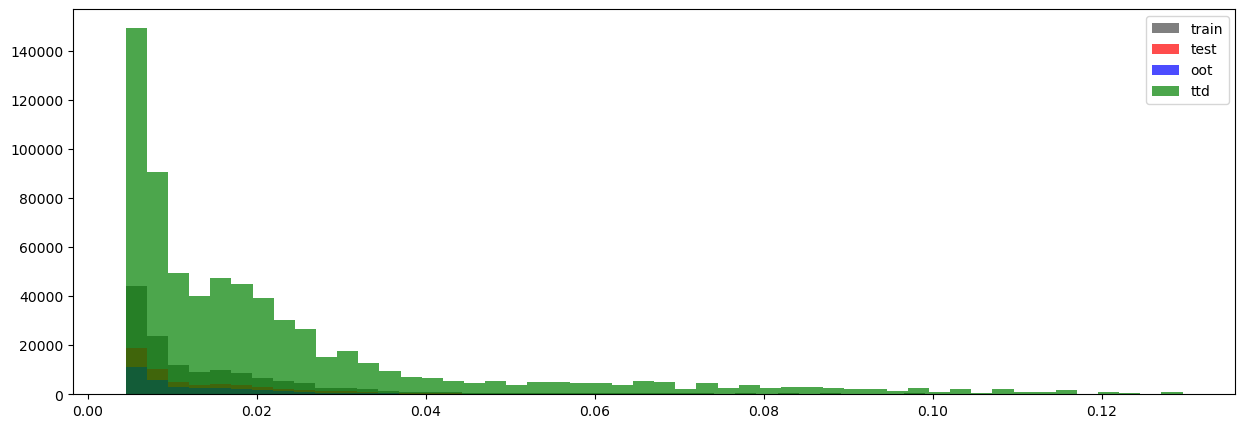

In [87]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 5))
plt.hist(Train['p1'], bins= 50, label= 'train', color= 'black', alpha= 0.5)
plt.hist(Test['p1'], bins= 50, label= 'test', color= 'red', alpha= 0.7)
plt.hist(Oot['p1'], bins= 50, label= 'oot', color= 'blue', alpha= 0.7)
plt.hist(TTD['p1'], bins= 50, label= 'ttd', color= 'green', alpha= 0.7)
plt.legend()
plt.show()

In [89]:
Train['p1'].value_counts(dropna= False).head()

p1
0.004476    5464
0.005524    2499
0.005296    2099
0.004735    1868
0.005054    1591
Name: count, dtype: int64

In [90]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     141943
[1]       4543
[2]        337
[-1]        32
Name: count, dtype: int64
bankruptcystatus
[0]     60829
[1]      1941
[2]       157
[-1]       11
Name: count, dtype: int64


In [91]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [92]:
df_bv= pd.DataFrame()

for col in col_list:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_P1', 'Train_Count']
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_P1', 'Test_Count']
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

assetownership
inquiryauto12month
inquiryshortterm12month
sourcenonderogcount12month
assetpropevercount
inquirytelcom12month
sourcenonderogcount
derogcount
addrlastmovetaxratiodiff
inquirynonshortterm12month
addrcurrenttaxmarketvalue
addrinputtaxvalue
criminalnonfelonycount
evictioncount
derogcount12month
addrinputtimenewest
addrprevioustimeoldest
educationprogramattended
criminalfelonycount
educationattendance
addrinputlengthofres
addrcurrentblockratio
addrinputtaxmarketvalue
bankruptcydismissed24month
addrchangecount03month
inquirycollections12month
inquirybanking12month
bankruptcychapter
addrinputsubjectcount
addrchangecount24month
addrcurrentdeedmailing
addrinputdeedmailing
addrchangecount06month
lienjudgmentcount
lienjudgmentsmallclaimscount
addrpreviouslengthofres
bankruptcystatus
assetpropnewestmortgagetype
bankruptcycount24month
assetproppurchasetimeoldest
assetproppurchasetimenewest
criminalnonfelonycount12month
assetpersonalcount
addrchangecount60month
addrinputtimelastsale
a

In [93]:
pd.options.display.max_rows= 1000
df_bv

,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetownership,[0],1606.0,0.029652,0.032304,54162,691.0,0.029889,0.032387,23119.0,Yes
1,assetownership,[1],621.0,0.006700,0.008729,92693,268.0,0.006730,0.008731,39819.0,Yes
2,inquiryauto12month,[0],1496.0,0.011491,0.013424,130194,647.0,0.011612,0.013371,55716.0,Yes
3,inquiryauto12month,[1],731.0,0.043875,0.048682,16661,312.0,0.043201,0.048661,7222.0,Yes
4,inquiryshortterm12month,[0],2005.0,0.013959,0.016974,143630,882.0,0.014330,0.016984,61551.0,Yes
5,inquiryshortterm12month,[1],222.0,0.068837,0.037462,3225,77.0,0.055516,0.036797,1387.0,Yes
6,sourcenonderogcount12month,"[-inf, 2.0)",1730.0,0.023668,0.024111,73094,726.0,0.023263,0.024103,31209.0,Yes
7,sourcenonderogcount12month,"[2.0, inf)",497.0,0.006738,0.010797,73761,233.0,0.007343,0.010848,31729.0,Yes
8,assetpropevercount,"[-inf, 1.0)",1526.0,0.030046,0.032887,50788,663.0,0.030656,0.032987,21627.0,Yes
9,assetpropevercount,"[1.0, 2.0)",445.0,0.008564,0.009601,51963,204.0,0.009101,0.009649,22414.0,Yes


In [94]:
for client in Train['client'].unique():
    print(client)
    get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
                  data= Train[Train['client']== client], 
                  data_h2o= train_h2o[train_h2o['client']== client], 
                  target= 'bad_flag', 
                  cols_tuple= col_tuple_pass, 
                  score_col= 'p1', 
                  weight= 'conwt')
    

Tower
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
30041 572.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.020864,0.128902,0.040817,6009,5695.0,314.0,5.23,20.0,19.33,54.90,35.57
1,0.012315,0.020862,0.016378,6008,5882.0,126.0,2.10,40.0,39.29,76.92,37.63
2,0.007377,0.012315,0.009331,6008,5936.0,72.0,1.20,60.0,59.43,89.51,30.08
3,0.005729,0.007377,0.006490,6008,5969.0,39.0,0.65,80.0,79.68,96.33,16.65
4,0.004476,0.005729,0.005067,6008,5987.0,21.0,0.35,100.0,100.00,100.00,0.00


{'Gini': 47.97, 'KS': 37.63}
GESA
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19768 402.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.027995,0.128902,0.052349,3954,3757.0,197.0,4.98,20.0,19.40,49.00,29.60
1,0.018343,0.027995,0.022512,3954,3849.0,105.0,2.66,40.0,39.28,75.12,35.84
2,0.010318,0.018343,0.014606,3953,3885.0,68.0,1.72,60.0,59.34,92.04,32.70
3,0.006468,0.010318,0.007971,3954,3928.0,26.0,0.66,80.0,79.62,98.51,18.89
4,0.004476,0.006468,0.005464,3953,3947.0,6.0,0.15,100.0,100.00,100.00,0.00


{'Gini': 46.81, 'KS': 35.84}
Hawaii
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
1438 3.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.025124,0.120360,0.043663,288,287.0,1.0,0.35,20.03,20.00,33.33,13.33
1,0.018519,0.025124,0.021477,288,288.0,0.0,0.00,40.06,40.07,33.33,6.74
2,0.013839,0.018519,0.016475,287,286.0,1.0,0.35,60.01,60.00,66.67,6.67
3,0.008769,0.013773,0.011052,288,288.0,0.0,0.00,80.04,80.07,66.67,13.40
4,0.004476,0.008760,0.006852,287,286.0,1.0,0.35,100.00,100.00,100.00,0.00


{'Gini': -0.05, 'KS': 13.4}
Guardian
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19177 268.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.031738,0.128902,0.060786,3836,3689.0,147.0,3.83,20.0,19.51,54.85,35.34
1,0.017997,0.031738,0.023444,3835,3775.0,60.0,1.56,40.0,39.47,77.24,37.77
2,0.010522,0.017995,0.014223,3836,3800.0,36.0,0.94,60.0,59.57,90.67,31.10
3,0.006890,0.010522,0.008475,3835,3822.0,13.0,0.34,80.0,79.78,95.52,15.74
4,0.004476,0.006890,0.005677,3835,3823.0,12.0,0.31,100.0,100.00,100.00,0.00


{'Gini': 47.980000000000004, 'KS': 37.77}
SECU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
12804 320.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.026360,0.128902,0.054711,2561,2380.0,181.0,7.07,20.00,19.06,56.56,37.50
1,0.016432,0.026360,0.020487,2561,2478.0,83.0,3.24,40.00,38.91,82.50,43.59
2,0.008295,0.016432,0.012437,2561,2527.0,34.0,1.33,60.00,59.16,93.12,33.96
3,0.006037,0.008295,0.006943,2561,2545.0,16.0,0.62,80.01,79.54,98.12,18.58
4,0.004476,0.006037,0.005210,2560,2554.0,6.0,0.23,100.00,100.00,100.00,0.00


{'Gini': 53.459999999999994, 'KS': 43.59}
Arkansas
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
27867 167.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.018149,0.128902,0.036584,5574,5479.0,95.0,1.70,20.0,19.78,56.89,37.11
1,0.010810,0.018149,0.013924,5573,5537.0,36.0,0.65,40.0,39.77,78.44,38.67
2,0.007561,0.010810,0.008856,5574,5562.0,12.0,0.22,60.0,59.85,85.63,25.78
3,0.005729,0.007561,0.006584,5573,5557.0,16.0,0.29,80.0,79.91,95.21,15.30
4,0.004476,0.005729,0.005044,5573,5565.0,8.0,0.14,100.0,100.00,100.00,0.00


{'Gini': 46.739999999999995, 'KS': 38.67}
Numerica
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
18091 297.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023582,0.128902,0.040551,3619,3494.0,125.0,3.45,20.0,19.64,42.09,22.45
1,0.014799,0.023582,0.018889,3618,3527.0,91.0,2.52,40.0,39.46,72.73,33.27
2,0.008636,0.014788,0.011215,3618,3572.0,46.0,1.27,60.0,59.53,88.22,28.69
3,0.006309,0.008635,0.007351,3618,3596.0,22.0,0.61,80.0,79.74,95.62,15.88
4,0.004476,0.006309,0.005457,3618,3605.0,13.0,0.36,100.0,100.00,100.00,0.00


{'Gini': 40.11, 'KS': 33.27}
CPM
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6702 94.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019777,0.122124,0.039492,1341,1293.0,48.0,3.58,20.01,19.57,51.06,31.49
1,0.011888,0.019764,0.015480,1340,1315.0,25.0,1.87,40.00,39.47,77.66,38.19
2,0.007570,0.011888,0.009380,1341,1332.0,9.0,0.67,60.01,59.62,87.23,27.61
3,0.005814,0.007562,0.006635,1340,1331.0,9.0,0.67,80.01,79.77,96.81,17.04
4,0.004476,0.005807,0.005091,1340,1337.0,3.0,0.22,100.00,100.00,100.00,0.00


{'Gini': 45.73, 'KS': 38.19}
Bethpage
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
8328 63.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019473,0.122124,0.037279,1666,1640.0,26.0,1.56,20.00,19.84,41.27,21.43
1,0.013164,0.019473,0.015879,1666,1654.0,12.0,0.72,40.01,39.85,60.32,20.47
2,0.007149,0.013158,0.009810,1665,1655.0,10.0,0.60,60.00,59.88,76.19,16.31
3,0.005296,0.007149,0.006048,1666,1655.0,11.0,0.66,80.01,79.90,93.65,13.75
4,0.004476,0.005296,0.004757,1665,1661.0,4.0,0.24,100.00,100.00,100.00,0.00


{'Gini': 28.78, 'KS': 21.43}
HFCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
2044 33.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.021353,0.115807,0.041276,409,397.0,12.0,2.93,20.01,19.74,36.36,16.62
1,0.013773,0.021291,0.017262,409,396.0,13.0,3.18,40.02,39.43,75.76,36.33
2,0.007802,0.013773,0.010584,409,404.0,5.0,1.22,60.03,59.52,90.91,31.39
3,0.005524,0.007798,0.006448,409,407.0,2.0,0.49,80.04,79.76,96.97,17.21
4,0.004476,0.005524,0.004804,408,407.0,1.0,0.25,100.00,100.00,100.00,0.00


{'Gini': 40.63, 'KS': 36.33}
NCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
595 8.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.025124,0.127231,0.048544,120,114.0,6.0,5.00,20.17,19.42,75.0,55.58
1,0.016104,0.025124,0.020103,118,116.0,2.0,1.69,40.00,39.18,100.0,60.82
2,0.009685,0.016053,0.012835,120,120.0,0.0,0.00,60.17,59.63,100.0,40.37
3,0.006034,0.009511,0.007466,119,119.0,0.0,0.00,80.17,79.90,100.0,20.10
4,0.004476,0.006015,0.005086,118,118.0,0.0,0.00,100.00,100.00,100.0,0.00


{'Gini': 70.78, 'KS': 60.82}


### Basic Checks

In [95]:
TTD['funded_flag'].sum(), Train['funded_flag'].sum(), Test['funded_flag'].sum()

(200148.0, 146855.0, 62938.0)

In [96]:
TTD['id']= TTD['unique_id']+TTD['client']
Train['id']= Train['unique_id']+Train['client']
Test['id']= Test['unique_id']+Test['client']
Oot['id']= Oot['unique_id']+Oot['client']

In [97]:
Train[(Train['id'].isin(TTD['id'].unique())) & (Train['client']!= 'CPM')].shape, Train[Train['client']!='CPM'].shape

((140153, 147), (140153, 147))

In [98]:
Test[(Test['id'].isin(TTD['id'].unique())) & (Test['client']!= 'CPM')].shape, Test[Test['client']!='CPM'].shape

((59995, 147), (59995, 147))

In [99]:
Train[(Train['id'].isin(Test['id'].unique()))].shape

(0, 147)

In [100]:
TTD[TTD['id'].isin(Train[Train['client']!= 'CPM']['id'].unique())]['p1'].describe(), Train[Train['client']!= 'CPM']['p1'].describe()

(count    140153.000000
 mean          0.017529
 std           0.018388
 min           0.004476
 25%           0.006461
 50%           0.010666
 75%           0.020689
 max           0.128902
 Name: p1, dtype: float64,
 count    140153.000000
 mean          0.017529
 std           0.018388
 min           0.004476
 25%           0.006461
 50%           0.010666
 75%           0.020689
 max           0.128902
 Name: p1, dtype: float64)

In [101]:
Train['client'].value_counts(dropna= False)

client
Tower       30041
Arkansas    27867
GESA        19768
Guardian    19177
Numerica    18091
SECU        12804
Bethpage     8328
CPM          6702
HFCU         2044
Hawaii       1438
NCU           595
Name: count, dtype: int64

In [102]:
import datetime
pref= 'With_LDA'
# Train[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Train_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# Test[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Test_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# Oot[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Oot_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# TTD[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_TTD_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)

In [103]:
TTD['fico_cut']= np.where(((TTD['fico_pb'].isnull()) |(TTD['fico_pb']<300)),"h.Missing",
                        np.where((TTD['fico_pb']>=300) &(TTD['fico_pb']<550),"a.300-550",
                                 np.where((TTD['fico_pb']>=550) &(TTD['fico_pb']<600),"a.550-600",
                                np.where((TTD['fico_pb']>=600) &(TTD['fico_pb']<630),"b.600-629",
                                    np.where((TTD['fico_pb']>=630) &(TTD['fico_pb']<660),"c.630-659",
                                        np.where((TTD['fico_pb']>=660) &(TTD['fico_pb']<690),"d.660-689",
                                            np.where((TTD['fico_pb']>=690) &(TTD['fico_pb']<715),"e.690-714",
                                                np.where((TTD['fico_pb']>=715) & (TTD['fico_pb']<740),"f.715-739",
                                                    np.where((TTD['fico_pb']>=740),"g.740+","h.Missing")))))))))

In [104]:
TTD.groupby('fico_cut').agg(
    ttd= ('unique_id', 'count'),
    approved= ('approve_flag', 'sum'),
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    avg_pd= ('p1', 'mean')
)

,ttd,approved,funded,bad,avg_pd
fico_cut,,,,,
a.300-550,35333,2873.0,1857.0,126.0,0.042557
a.550-600,52785,13360.0,5376.0,346.0,0.037078
b.600-629,57138,23516.0,7940.0,386.0,0.032125
c.630-659,78628,39076.0,15179.0,554.0,0.027247
d.660-689,90338,52831.0,24815.0,511.0,0.022733
e.690-714,73120,48229.0,23877.0,300.0,0.019396
f.715-739,62889,45175.0,23083.0,186.0,0.017590
g.740+,199076,167515.0,93215.0,243.0,0.012330
h.Missing,35908,9030.0,4806.0,395.0,0.033668


In [105]:
TTD.shape

(685215, 148)